In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'legend.fontsize': 14})
#plt.rcParams['font.family'] = 'times'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.minor.size'] = 3
import uproot

In [2]:
##### function definitions
# different definitions of hadronic energy
def cal_Ehadtrue(pdg, E, m):
    Ehadtrue = 0
    for ip in range(len(pdg)):
        if pdg[ip] in [2212, 2112]:
            Ehadtrue += (E[ip] - m[ip])
        elif pdg[ip] in [211, -211, 111, 22, 321, -321, 311]:
            Ehadtrue += E[ip]
    return Ehadtrue
def cal_Ehadreco(pdg, E, m):
    Ehadreco = 0
    for ip in range(len(pdg)):
        if pdg[ip] in [2212]:
            Ehadreco += (E[ip] - m[ip])
        elif pdg[ip] in [211, -211, 111, 22, 321, -321, 311]:
            Ehadreco += E[ip]
    return Ehadreco
def cal_Eavail(pdg, E, m):
    Eavail = 0
    for ip in range(len(pdg)):
        if pdg[ip] in [2212, 211, -211]:
            Eavail += (E[ip] - m[ip])
        elif pdg[ip] in [111, 22, 321, -321, 311]:
            Eavail += E[ip]
    return Eavail
def get_Ehad_array(vars_dict, cal_Ehad_func):
    nevts = len(vars_dict["Ev"])
    pdgi = vars_dict["pdgi"]
    Ei = vars_dict["Ei"]
    mi = []
    Eavail_i = []
    pdgf = vars_dict["pdgf"]
    Ef = vars_dict["Ef"]
    mf = []
    Eavail_f = []
    
    for ievt in range(nevts):
        pisq = vars_dict["pxi"][ievt]*vars_dict["pxi"][ievt] + vars_dict["pyi"][ievt]*vars_dict["pyi"][ievt] + vars_dict["pzi"][ievt]*vars_dict["pzi"][ievt]
        mi.append(np.sqrt(Ei[ievt]*Ei[ievt] - pisq))
        Eavail_i.append(cal_Ehad_func(pdgi[ievt], Ei[ievt], mi[ievt]))
        
        mf.append(np.sqrt(Ef[ievt]*Ef[ievt] - vars_dict["pf"][ievt]*vars_dict["pf"][ievt]))
        Eavail_f.append(cal_Ehad_func(pdgf[ievt], Ef[ievt], mf[ievt]))
        
    return np.array(Eavail_i), np.array(Eavail_f)

# neutrino energy bias
def get_Ebias(vars_dict, cal_Ehad_func):
    Ehadi, Ehadf = get_Ehad_array(vars_dict, cal_Ehad_func)
    return vars_dict["El"] + Ehadi - vars_dict["Ev"], vars_dict["El"] + Ehadf - vars_dict["Ev"]
def get_relative_Ebias(vars_dict, cal_Ehad_func):
    Ebiasi, Ebiasf = get_Ebias(vars_dict, cal_Ehad_func)
    return Ebiasi / vars_dict["Ev"], Ebiasf / vars_dict["Ev"]

# other useful
def safe_divide(numerator, denominator, default_value=100):
    # 0/0 = 1, 0/x = 0, x/0 = default_value
    result = np.ones_like(numerator, dtype=float)  # Default result is 1
    mask_both_zero = (numerator == 0) & (denominator == 0)
    mask_only_denominator_zero = (denominator == 0) & ~mask_both_zero

    result[~mask_both_zero & ~mask_only_denominator_zero] = numerator[~mask_both_zero & ~mask_only_denominator_zero] / denominator[~mask_both_zero & ~mask_only_denominator_zero]
    result[mask_only_denominator_zero] = default_value  # Assign default value where denominator is zero and numerator is non-zero
    return np.nan_to_num(result, nan=default_value)  # Replace NaN with default_value

def fill_between_gradient(ax, x, y, y_upp, y_low,
                          alpha=0.3, resolution=1000, zorder=0,
                          cmap=None, label=None):
    """
    Draw a vertical red-white-blue gradient between y_upp and y_low on the given axes.
    White is centered at y(x), red at y_upp, and blue at y_low.

    Parameters:
    - ax: matplotlib Axes object
    - x: 1D array of x-coordinates
    - y: 1D array for the white center line
    - y_upp: 1D array for the red-side boundary
    - y_low: 1D array for the blue-side boundary
    - alpha: float (0 to 1), maximum opacity of the fill
    - resolution: int, resolution for the rendered gradient image
    - zorder: drawing layer
    - cmap: optional colormap (default is red-white-blue)
    - label: optional label (not used in legend but allows consistent API)
    """
    import numpy as np
    from scipy.interpolate import interp1d
    from matplotlib.colors import LinearSegmentedColormap

    if cmap is None:
        cmap = LinearSegmentedColormap.from_list("rwb", ["blue", "white", "red"])

    # Ensure input as arrays
    x = np.asarray(x)
    y = np.asarray(y)
    y_upp = np.asarray(y_upp)
    y_low = np.asarray(y_low)

    dy = (y_upp - y_low) / 2

    # Create meshgrid for plotting
    nx, ny = resolution, resolution
    X = np.linspace(x.min(), x.max(), nx)
    Y = np.linspace(min(y_upp.min(), y_low.min()) - 0.2,
                    max(y_upp.max(), y_low.max()) + 0.2, ny)
    XX, YY = np.meshgrid(X, Y)

    # Interpolate center and width to the mesh x values
    center_func = interp1d(x, y, bounds_error=False, fill_value="extrapolate")
    dy_func = interp1d(x, dy, bounds_error=False, fill_value="extrapolate")
    y0 = center_func(X)
    dy_vals = dy_func(X)

    # Interpolate upper/lower bounds *before* evaluating the mask
    y_upp_interp = interp1d(x, y_upp, bounds_error=False, fill_value="extrapolate")(X)
    y_low_interp = interp1d(x, y_low, bounds_error=False, fill_value="extrapolate")(X)
    y_top = np.maximum(y_upp_interp, y_low_interp)
    y_bot = np.minimum(y_upp_interp, y_low_interp)

    # Safe division to normalize gradient [-1, 1]
    def safe_divide(numerator, denominator, default_value=100):
        numerator, denominator = np.broadcast_arrays(numerator, denominator)
        result = np.ones_like(numerator)
        mask_both_zero = (numerator == 0) & (denominator == 0)
        mask_only_zero = (denominator == 0) & ~mask_both_zero
        mask_valid = ~mask_both_zero & ~mask_only_zero
        result[mask_valid] = numerator[mask_valid] / denominator[mask_valid]
        result[mask_only_zero] = default_value
        return np.nan_to_num(result, nan=default_value)

    norm_val = safe_divide(YY - y0, dy_vals)
    norm_val = np.clip(norm_val, -1, 1)

    # Alpha mask: only show pixels between the two bounds
    alpha_mask = ((YY >= y_bot) & (YY <= y_top)).astype(float) * alpha

    # Draw the image
    ax.imshow(norm_val,
              extent=[X.min(), X.max(), Y.min(), Y.max()],
              origin='lower',
              aspect='auto',
              cmap=cmap,
              alpha=alpha_mask,
              zorder=zorder,
              label=label)


### nue appearance

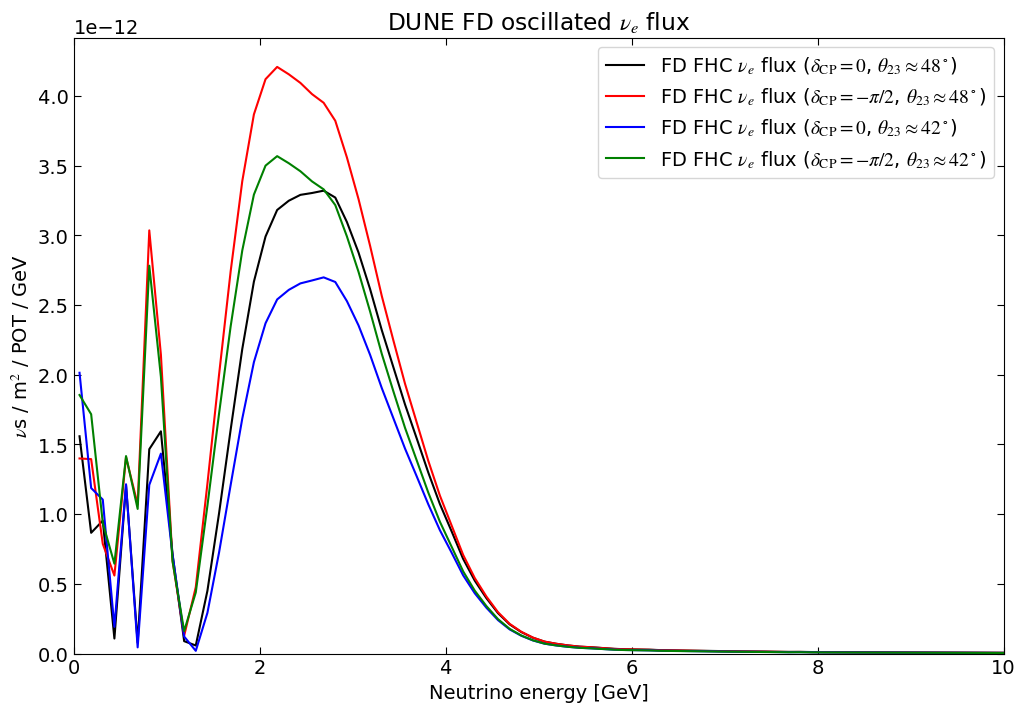

In [3]:
# nue appearance
FDosc_Ev = np.array([0.0625,0.1875,0.3125,0.4375,0.5625,0.6875,0.8125,0.9375,1.0625,1.1875,1.3125,1.4375,1.5625,1.6875,1.8125,1.9375,2.0625,2.1875,2.3125,2.4375,2.5625,2.6875,2.8125,2.9375,3.0625,3.1875,3.3125,3.4375,3.5625,3.6875,3.8125,3.9375,4.0625,4.1875,4.3125,4.4375,4.5625,4.6875,4.8125,4.9375,5.0625,5.1875,5.3125,5.4375,5.5625,5.6875,5.8125,5.9375,6.0625,6.1875,6.3125,6.4375,6.5625,6.6875,6.8125,6.9375,7.0625,7.1875,7.3125,7.4375,7.5625,7.6875,7.8125,7.9375,8.0625,8.1875,8.3125,8.4375,8.5625,8.6875,8.8125,8.9375,9.0625,9.1875,9.3125,9.4375,9.5625,9.6875,9.8125,9.9375,10.0625,10.1875,10.3125,10.4375,10.5625,10.6875,10.8125,10.9375,11.0625,11.1875,11.3125,11.4375,11.5625,11.6875,11.8125,11.9375,12.0625,12.1875,12.3125,12.4375,12.5625,12.6875,12.8125,12.9375,13.0625,13.1875,13.3125,13.4375,13.5625,13.6875,13.8125,13.9375,14.0625,14.1875,14.3125,14.4375,14.5625,14.6875,14.8125,14.9375,15.0625,15.1875,15.3125,15.4375,15.5625,15.6875,15.8125,15.9375,16.0625,16.1875,16.3125,16.4375,16.5625,16.6875,16.8125,16.9375,17.0625,17.1875,17.3125,17.4375,17.5625,17.6875,17.8125,17.9375,18.0625,18.1875,18.3125,18.4375,18.5625,18.6875,18.8125,18.9375,19.0625,19.1875,19.3125,19.4375,19.5625,19.6875,19.8125,19.9375,20.0625,20.1875,20.3125,20.4375,20.5625,20.6875,20.8125,20.9375,21.0625,21.1875,21.3125,21.4375,21.5625,21.6875,21.8125,21.9375,22.0625,22.1875,22.3125,22.4375,22.5625,22.6875,22.8125,22.9375,23.0625,23.1875,23.3125,23.4375,23.5625,23.6875,23.8125,23.9375,24.0625,24.1875,24.3125,24.4375,24.5625,24.6875,24.8125,24.9375,25.0625,25.1875,25.3125,25.4375,25.5625,25.6875,25.8125,25.9375,26.0625,26.1875,26.3125,26.4375,26.5625,26.6875,26.8125,26.9375,27.0625,27.1875,27.3125,27.4375,27.5625,27.6875,27.8125,27.9375,28.0625,28.1875,28.3125,28.4375,28.5625,28.6875,28.8125,28.9375,29.0625,29.1875,29.3125,29.4375,29.5625,29.6875,29.8125,29.9375,30.0625,30.1875,30.3125,30.4375,30.5625,30.6875,30.8125,30.9375,31.0625,31.1875,31.3125,31.4375,31.5625,31.6875,31.8125,31.9375,32.0625,32.1875,32.3125,32.4375,32.5625,32.6875,32.8125,32.9375,33.0625,33.1875,33.3125,33.4375,33.5625,33.6875,33.8125,33.9375,34.0625,34.1875,34.3125,34.4375,34.5625,34.6875,34.8125,34.9375,35.0625,35.1875,35.3125,35.4375,35.5625,35.6875,35.8125,35.9375,36.0625,36.1875,36.3125,36.4375,36.5625,36.6875,36.8125,36.9375,37.0625,37.1875,37.3125,37.4375,37.5625,37.6875,37.8125,37.9375,38.0625,38.1875,38.3125,38.4375,38.5625,38.6875,38.8125,38.9375,39.0625,39.1875,39.3125,39.4375,39.5625,39.6875,39.8125,39.9375,40.0625,40.1875,40.3125,40.4375,40.5625,40.6875,40.8125,40.9375,41.0625,41.1875,41.3125,41.4375,41.5625,41.6875,41.8125,41.9375,42.0625,42.1875,42.3125,42.4375,42.5625,42.6875,42.8125,42.9375,43.0625,43.1875,43.3125,43.4375,43.5625,43.6875,43.8125,43.9375,44.0625,44.1875,44.3125,44.4375,44.5625,44.6875,44.8125,44.9375,45.0625,45.1875,45.3125,45.4375,45.5625,45.6875,45.8125,45.9375,46.0625,46.1875,46.3125,46.4375,46.5625,46.6875,46.8125,46.9375,47.0625,47.1875,47.3125,47.4375,47.5625,47.6875,47.8125,47.9375,48.0625,48.1875,48.3125,48.4375,48.5625,48.6875,48.8125,48.9375,49.0625,49.1875,49.3125,49.4375,49.5625,49.6875,49.8125,49.9375,50.0625,50.1875,50.3125,50.4375,50.5625,50.6875,50.8125,50.9375,51.0625,51.1875,51.3125,51.4375,51.5625,51.6875,51.8125,51.9375,52.0625,52.1875,52.3125,52.4375,52.5625,52.6875,52.8125,52.9375,53.0625,53.1875,53.3125,53.4375,53.5625,53.6875,53.8125,53.9375,54.0625,54.1875,54.3125,54.4375,54.5625,54.6875,54.8125,54.9375,55.0625,55.1875,55.3125,55.4375,55.5625,55.6875,55.8125,55.9375,56.0625,56.1875,56.3125,56.4375,56.5625,56.6875,56.8125,56.9375,57.0625,57.1875,57.3125,57.4375,57.5625,57.6875,57.8125,57.9375,58.0625,58.1875,58.3125,58.4375,58.5625,58.6875,58.8125,58.9375,59.0625,59.1875,59.3125,59.4375,59.5625,59.6875,59.8125,59.9375,60.0625,60.1875,60.3125,60.4375,60.5625,60.6875,60.8125,60.9375,61.0625,61.1875,61.3125,61.4375,61.5625,61.6875,61.8125,61.9375,62.0625,62.1875,62.3125,62.4375,62.5625,62.6875,62.8125,62.9375,63.0625,63.1875,63.3125,63.4375,63.5625,63.6875,63.8125,63.9375,64.0625,64.1875,64.3125,64.4375,64.5625,64.6875,64.8125,64.9375,65.0625,65.1875,65.3125,65.4375,65.5625,65.6875,65.8125,65.9375,66.0625,66.1875,66.3125,66.4375,66.5625,66.6875,66.8125,66.9375,67.0625,67.1875,67.3125,67.4375,67.5625,67.6875,67.8125,67.9375,68.0625,68.1875,68.3125,68.4375,68.5625,68.6875,68.8125,68.9375,69.0625,69.1875,69.3125,69.4375,69.5625,69.6875,69.8125,69.9375])
ND_Flux_FHCnue = np.array([5.15699e-07,1.21122e-06,1.74857e-06,2.20644e-06,2.48005e-06,2.54447e-06,2.62088e-06,2.75281e-06,2.70366e-06,2.77766e-06,2.45346e-06,2.4691e-06,2.60725e-06,2.04054e-06,2.29401e-06,1.95703e-06,1.90302e-06,1.77282e-06,1.89262e-06,2.08815e-06,1.54245e-06,1.7701e-06,1.63854e-06,1.39396e-06,1.26384e-06,1.137e-06,1.22722e-06,1.19621e-06,1.19905e-06,1.09156e-06,1.12308e-06,1.01237e-06,9.14547e-07,8.81169e-07,8.45858e-07,7.45673e-07,7.75367e-07,6.24508e-07,7.53834e-07,6.26923e-07,6.09703e-07,6.81877e-07,5.93795e-07,5.53923e-07,5.20964e-07,4.9104e-07,5.34016e-07,5.82939e-07,5.67265e-07,4.62913e-07,4.34054e-07,4.07838e-07,4.48648e-07,4.6365e-07,3.82894e-07,3.86535e-07,3.90581e-07,3.25995e-07,3.34976e-07,3.26117e-07,3.24468e-07,3.20592e-07,3.17899e-07,3.09246e-07,2.93394e-07,2.93394e-07,2.93394e-07,2.93394e-07,2.70885e-07,2.70885e-07,2.70885e-07,2.70885e-07,2.3164e-07,2.3164e-07,2.3164e-07,2.3164e-07,2.10864e-07,2.10864e-07,2.10864e-07,2.10864e-07,1.92e-07,1.92e-07,1.92e-07,1.92e-07,1.6179e-07,1.6179e-07,1.6179e-07,1.6179e-07,1.46477e-07,1.46477e-07,1.46477e-07,1.46477e-07,1.28858e-07,1.28858e-07,1.28858e-07,1.28858e-07,1.08777e-07,1.08777e-07,1.08777e-07,1.08777e-07,1.00789e-07,1.00789e-07,1.00789e-07,1.00789e-07,9.22061e-08,9.22061e-08,9.22061e-08,9.22061e-08,8.78693e-08,8.78693e-08,8.78693e-08,8.78693e-08,7.82883e-08,7.82883e-08,7.82883e-08,7.82883e-08,6.71194e-08,6.71194e-08,6.71194e-08,6.71194e-08,5.57204e-08,5.57204e-08,5.57204e-08,5.57204e-08,5.03643e-08,5.03643e-08,5.03643e-08,5.03643e-08,4.41445e-08,4.41445e-08,4.41445e-08,4.41445e-08,4.14333e-08,4.14333e-08,4.14333e-08,4.14333e-08,3.49222e-08,3.49222e-08,3.49222e-08,3.49222e-08,3.91092e-08,3.91092e-08,3.91092e-08,3.91092e-08,2.89281e-08,2.89281e-08,2.89281e-08,2.89281e-08,2.89036e-08,2.89036e-08,2.89036e-08,2.89036e-08,3.02013e-08,3.02013e-08,3.02013e-08,3.02013e-08,2.49808e-08,2.49808e-08,2.49808e-08,2.49808e-08,1.96701e-08,1.96701e-08,1.96701e-08,1.96701e-08,1.96701e-08,1.96701e-08,1.96701e-08,1.96701e-08,1.96701e-08,1.96701e-08,1.96701e-08,1.96701e-08,1.96701e-08,1.96701e-08,1.96701e-08,1.96701e-08,1.44797e-08,1.44797e-08,1.44797e-08,1.44797e-08,1.44797e-08,1.44797e-08,1.44797e-08,1.44797e-08,1.44797e-08,1.44797e-08,1.44797e-08,1.44797e-08,1.44797e-08,1.44797e-08,1.44797e-08,1.44797e-08,1.02435e-08,1.02435e-08,1.02435e-08,1.02435e-08,1.02435e-08,1.02435e-08,1.02435e-08,1.02435e-08,1.02435e-08,1.02435e-08,1.02435e-08,1.02435e-08,1.02435e-08,1.02435e-08,1.02435e-08,1.02435e-08,9.57227e-09,9.57227e-09,9.57227e-09,9.57227e-09,9.57227e-09,9.57227e-09,9.57227e-09,9.57227e-09,9.57227e-09,9.57227e-09,9.57227e-09,9.57227e-09,9.57227e-09,9.57227e-09,9.57227e-09,9.57227e-09,4.66897e-09,4.66897e-09,4.66897e-09,4.66897e-09,4.66897e-09,4.66897e-09,4.66897e-09,4.66897e-09,4.66897e-09,4.66897e-09,4.66897e-09,4.66897e-09,4.66897e-09,4.66897e-09,4.66897e-09,4.66897e-09,3.50862e-09,3.50862e-09,3.50862e-09,3.50862e-09,3.50862e-09,3.50862e-09,3.50862e-09,3.50862e-09,3.50862e-09,3.50862e-09,3.50862e-09,3.50862e-09,3.50862e-09,3.50862e-09,3.50862e-09,3.50862e-09,3.09164e-09,3.09164e-09,3.09164e-09,3.09164e-09,3.09164e-09,3.09164e-09,3.09164e-09,3.09164e-09,3.09164e-09,3.09164e-09,3.09164e-09,3.09164e-09,3.09164e-09,3.09164e-09,3.09164e-09,3.09164e-09,3.74484e-09,3.74484e-09,3.74484e-09,3.74484e-09,3.74484e-09,3.74484e-09,3.74484e-09,3.74484e-09,3.74484e-09,3.74484e-09,3.74484e-09,3.74484e-09,3.74484e-09,3.74484e-09,3.74484e-09,3.74484e-09,5.37653e-10,5.37653e-10,5.37653e-10,5.37653e-10,5.37653e-10,5.37653e-10,5.37653e-10,5.37653e-10,5.37653e-10,5.37653e-10,5.37653e-10,5.37653e-10,5.37653e-10,5.37653e-10,5.37653e-10,5.37653e-10,4.78397e-10,4.78397e-10,4.78397e-10,4.78397e-10,4.78397e-10,4.78397e-10,4.78397e-10,4.78397e-10,4.78397e-10,4.78397e-10,4.78397e-10,4.78397e-10,4.78397e-10,4.78397e-10,4.78397e-10,4.78397e-10,2.15922e-09,2.15922e-09,2.15922e-09,2.15922e-09,2.15922e-09,2.15922e-09,2.15922e-09,2.15922e-09,2.15922e-09,2.15922e-09,2.15922e-09,2.15922e-09,2.15922e-09,2.15922e-09,2.15922e-09,2.15922e-09,1.20341e-09,1.20341e-09,1.20341e-09,1.20341e-09,1.20341e-09,1.20341e-09,1.20341e-09,1.20341e-09,1.20341e-09,1.20341e-09,1.20341e-09,1.20341e-09,1.20341e-09,1.20341e-09,1.20341e-09,1.20341e-09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.05667e-10,3.05667e-10,3.05667e-10,3.05667e-10,3.05667e-10,3.05667e-10,3.05667e-10,3.05667e-10,3.05667e-10,3.05667e-10,3.05667e-10,3.05667e-10,3.05667e-10,3.05667e-10,3.05667e-10,3.05667e-10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9.99568e-10,9.99568e-10,9.99568e-10,9.99568e-10,9.99568e-10,9.99568e-10,9.99568e-10,9.99568e-10,9.99568e-10,9.99568e-10,9.99568e-10,9.99568e-10,9.99568e-10,9.99568e-10,9.99568e-10,9.99568e-10,5.22287e-10,5.22287e-10,5.22287e-10,5.22287e-10,5.22287e-10,5.22287e-10,5.22287e-10,5.22287e-10,5.22287e-10,5.22287e-10,5.22287e-10,5.22287e-10,5.22287e-10,5.22287e-10,5.22287e-10,5.22287e-10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.69722e-10,5.69722e-10,5.69722e-10,5.69722e-10,5.69722e-10,5.69722e-10,5.69722e-10,5.69722e-10,5.69722e-10,5.69722e-10,5.69722e-10,5.69722e-10,5.69722e-10,5.69722e-10,5.69722e-10,5.69722e-10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
# dcp == 0 ± pi/10, theta_23 ≈ 48.3
FDosc_Flux_FHCnue_1300 = np.array([1.55872e-12,8.66281e-13,9.53601e-13,1.07914e-13,1.20695e-12,7.77098e-14,1.46605e-12,1.59428e-12,7.14966e-13,8.91012e-14,5.79061e-14,4.50031e-13,1.00477e-12,1.60616e-12,2.18489e-12,2.66783e-12,2.99136e-12,3.18179e-12,3.24805e-12,3.29026e-12,3.30355e-12,3.32035e-12,3.27086e-12,3.09543e-12,2.87656e-12,2.61283e-12,2.31999e-12,2.05296e-12,1.78672e-12,1.54448e-12,1.2989e-12,1.07242e-12,8.78267e-13,6.79224e-13,5.23086e-13,3.97492e-13,2.89843e-13,2.09461e-13,1.54261e-13,1.13775e-13,8.56079e-14,7.04535e-14,5.88034e-14,5.01138e-14,4.56616e-14,3.9537e-14,3.40236e-14,3.10099e-14,2.94128e-14,2.7992e-14,2.4762e-14,2.32925e-14,2.20332e-14,2.05974e-14,1.92021e-14,1.8183e-14,1.68677e-14,1.55975e-14,1.52251e-14,1.45367e-14,1.31894e-14,1.20838e-14,1.23415e-14,1.09715e-14,1.04796e-14,1.01731e-14,9.87948e-15,9.59797e-15,8.77682e-15,8.53301e-15,8.29893e-15,8.07409e-15,7.26889e-15,7.07672e-15,6.89188e-15,6.71402e-15,6.4341e-15,6.27192e-15,6.11566e-15,5.96504e-15,5.27629e-15,5.14926e-15,5.02667e-15,4.90833e-15,4.45033e-15,4.34782e-15,4.24875e-15,4.15297e-15,3.85637e-15,3.77125e-15,3.68887e-15,3.60912e-15,3.29685e-15,3.22701e-15,3.15933e-15,3.09373e-15,2.88527e-15,2.82653e-15,2.76953e-15,2.71422e-15,2.46595e-15,2.41762e-15,2.37069e-15,2.32509e-15,2.18856e-15,2.14722e-15,2.10704e-15,2.06796e-15,1.88388e-15,1.84956e-15,1.81615e-15,1.78363e-15,1.65154e-15,1.62247e-15,1.59416e-15,1.56657e-15,1.42236e-15,1.39815e-15,1.37455e-15,1.35153e-15,1.31025e-15,1.28866e-15,1.2676e-15,1.24705e-15,1.11279e-15,1.09502e-15,1.07768e-15,1.06074e-15,9.05727e-16,8.91705e-16,8.78003e-16,8.64612e-16,7.85805e-16,7.73996e-16,7.62449e-16,7.51157e-16,6.53537e-16,6.43996e-16,6.34662e-16,6.25527e-16,5.21808e-16,5.14402e-16,5.07151e-16,5.00052e-16,4.08206e-16,4.02569e-16,3.97048e-16,3.91638e-16,3.47388e-16,3.42717e-16,3.3814e-16,3.33653e-16,2.94548e-16,2.9069e-16,2.86906e-16,2.83196e-16,2.61445e-16,2.58107e-16,2.54831e-16,2.51617e-16,2.33295e-16,2.30389e-16,2.27536e-16,2.24736e-16,2.21988e-16,2.19289e-16,2.16638e-16,2.14035e-16,2.11479e-16,2.08968e-16,2.06501e-16,2.04078e-16,2.01696e-16,1.99356e-16,1.97056e-16,1.94796e-16,1.57558e-16,1.5577e-16,1.54013e-16,1.52286e-16,1.50587e-16,1.48917e-16,1.47273e-16,1.45657e-16,1.44068e-16,1.42504e-16,1.40965e-16,1.39451e-16,1.37961e-16,1.36494e-16,1.35051e-16,1.33631e-16,1.04112e-16,1.03029e-16,1.01962e-16,1.00911e-16,9.98768e-17,9.88581e-17,9.78549e-17,9.68669e-17,9.58936e-17,9.4935e-17,9.39905e-17,9.30601e-17,9.21433e-17,9.124e-17,9.03499e-17,8.94727e-17,6.94408e-17,6.8773e-17,6.81148e-17,6.74659e-17,6.68263e-17,6.61957e-17,6.55739e-17,6.49608e-17,6.43563e-17,6.37602e-17,6.31722e-17,6.25924e-17,6.20204e-17,6.14563e-17,6.08997e-17,6.03507e-17,4.66932e-17,4.6276e-17,4.58643e-17,4.54581e-17,4.50573e-17,4.46617e-17,4.42713e-17,4.3886e-17,4.35056e-17,4.31302e-17,4.27596e-17,4.23938e-17,4.20326e-17,4.1676e-17,4.13239e-17,4.09763e-17,3.51604e-17,3.4867e-17,3.45773e-17,3.42912e-17,3.40086e-17,3.37295e-17,3.34538e-17,3.31814e-17,3.29124e-17,3.26466e-17,3.2384e-17,3.21246e-17,3.18682e-17,3.16149e-17,3.13647e-17,3.11173e-17,2.25739e-17,2.23973e-17,2.22227e-17,2.20502e-17,2.18796e-17,2.1711e-17,2.15444e-17,2.13797e-17,2.12168e-17,2.10558e-17,2.08966e-17,2.07393e-17,2.05836e-17,2.04298e-17,2.02776e-17,2.01271e-17,1.49123e-17,1.48025e-17,1.46938e-17,1.45864e-17,1.44801e-17,1.4375e-17,1.4271e-17,1.41681e-17,1.40664e-17,1.39657e-17,1.38661e-17,1.37676e-17,1.36701e-17,1.35736e-17,1.34782e-17,1.33838e-17,1.14508e-17,1.13711e-17,1.12923e-17,1.12143e-17,1.1137e-17,1.10606e-17,1.09849e-17,1.09101e-17,1.08359e-17,1.07626e-17,1.06899e-17,1.06181e-17,1.05469e-17,1.04764e-17,1.04067e-17,1.03376e-17,9.28236e-18,9.22117e-18,9.16057e-18,9.10057e-18,9.04116e-18,8.98232e-18,8.92406e-18,8.86636e-18,8.80921e-18,8.75262e-18,8.69657e-18,8.64106e-18,8.58607e-18,8.53161e-18,8.47766e-18,8.42423e-18,6.10936e-18,6.07109e-18,6.03318e-18,5.99562e-18,5.95842e-18,5.92155e-18,5.88503e-18,5.84884e-18,5.81299e-18,5.77746e-18,5.74226e-18,5.70738e-18,5.67282e-18,5.63856e-18,5.60462e-18,5.57098e-18,4.60782e-18,4.58033e-18,4.55308e-18,4.52608e-18,4.49931e-18,4.47279e-18,4.44649e-18,4.42043e-18,4.39459e-18,4.36898e-18,4.3436e-18,4.31843e-18,4.29348e-18,4.26875e-18,4.24423e-18,4.21992e-18,3.82293e-18,3.80115e-18,3.77957e-18,3.75816e-18,3.73694e-18,3.7159e-18,3.69503e-18,3.67434e-18,3.65382e-18,3.63347e-18,3.61329e-18,3.59328e-18,3.57344e-18,3.55376e-18,3.53424e-18,3.51488e-18,2.86852e-18,2.85289e-18,2.83739e-18,2.82202e-18,2.80677e-18,2.79164e-18,2.77663e-18,2.76175e-18,2.74699e-18,2.73234e-18,2.71781e-18,2.70339e-18,2.68909e-18,2.67491e-18,2.66083e-18,2.64687e-18,1.88577e-18,1.87593e-18,1.86616e-18,1.85647e-18,1.84685e-18,1.8373e-18,1.82784e-18,1.81844e-18,1.80911e-18,1.79986e-18,1.79068e-18,1.78157e-18,1.77253e-18,1.76355e-18,1.75465e-18,1.74581e-18,1.63636e-18,1.62816e-18,1.62002e-18,1.61194e-18,1.60392e-18,1.59596e-18,1.58806e-18,1.58022e-18,1.57243e-18,1.5647e-18,1.55703e-18,1.54942e-18,1.54186e-18,1.53436e-18,1.52691e-18,1.51952e-18,1.10052e-18,1.09521e-18,1.08995e-18,1.08472e-18,1.07953e-18,1.07438e-18,1.06926e-18,1.06418e-18,1.05914e-18,1.05413e-18,1.04916e-18,1.04422e-18,1.03932e-18,1.03445e-18,1.02961e-18,1.02481e-18,8.08765e-19,8.05012e-19,8.01285e-19,7.97583e-19,7.93907e-19,7.90256e-19,7.86631e-19,7.8303e-19,7.79454e-19,7.75903e-19,7.72375e-19,7.68872e-19,7.65392e-19,7.61936e-19,7.58503e-19,7.55094e-19,8.26069e-19,8.22372e-19,8.187e-19,8.15053e-19,8.1143e-19,8.07831e-19,8.04255e-19,8.00704e-19,7.97176e-19,7.93671e-19,7.90189e-19,7.8673e-19,7.83294e-19,7.7988e-19,7.76488e-19,7.73119e-19,4.64683e-19,4.62675e-19,4.6068e-19,4.58698e-19,4.56729e-19,4.54773e-19,4.52829e-19,4.50897e-19,4.48978e-19,4.47071e-19,4.45176e-19,4.43293e-19,4.41422e-19,4.39563e-19,4.37715e-19,4.3588e-19,4.8253e-19,4.80514e-19,4.78512e-19,4.76521e-19,4.74543e-19,4.72578e-19,4.70624e-19,4.68683e-19,4.66754e-19,4.64836e-19,4.6293e-19,4.61036e-19,4.59154e-19,4.57283e-19,4.55424e-19,4.53575e-19,3.07263e-19,3.06022e-19,3.04787e-19,3.0356e-19,3.02341e-19,3.01128e-19,2.99923e-19,2.98726e-19,2.97535e-19,2.96352e-19,2.95175e-19,2.94006e-19,2.92843e-19,2.91688e-19,2.90539e-19,2.89397e-19,2.10989e-19,2.10163e-19,2.09341e-19,2.08525e-19,2.07713e-19,2.06906e-19,2.06104e-19,2.05306e-19,2.04513e-19,2.03725e-19,2.02941e-19,2.02162e-19,2.01387e-19,2.00616e-19,1.9985e-19,1.99089e-19,2.73341e-19,2.72303e-19,2.71271e-19,2.70245e-19,2.69225e-19,2.68211e-19,2.67202e-19,2.66199e-19,2.65201e-19,2.6421e-19,2.63223e-19,2.62243e-19,2.61267e-19,2.60297e-19,2.59333e-19,2.58374e-19,1.44694e-19,1.4416e-19,1.4363e-19,1.43103e-19,1.42578e-19,1.42057e-19,1.41538e-19,1.41022e-19,1.40509e-19,1.39999e-19,1.39492e-19,1.38987e-19,1.38485e-19,1.37985e-19,1.37489e-19,1.36995e-19])
FDosc_Flux_FHCnue_1300p = np.array([1.65682e-12,8.76783e-13,9.3299e-13,1.10451e-13,1.10209e-12,4.75503e-14,1.28668e-12,1.45473e-12,6.70611e-13,9.32471e-14,6.19e-14,4.2976e-13,9.56099e-13,1.53131e-12,2.08848e-12,2.55655e-12,2.8732e-12,3.06247e-12,3.1321e-12,3.17816e-12,3.19587e-12,3.21659e-12,3.17265e-12,3.00597e-12,2.79641e-12,2.54253e-12,2.25963e-12,2.00124e-12,1.74308e-12,1.50787e-12,1.26899e-12,1.0484e-12,8.59117e-13,6.64794e-13,5.1225e-13,3.89457e-13,2.84122e-13,2.05421e-13,1.51352e-13,1.11675e-13,8.40612e-14,6.92067e-14,5.77835e-14,4.92615e-14,4.48998e-14,3.88896e-14,3.34765e-14,3.05201e-14,2.89563e-14,2.75649e-14,2.43905e-14,2.29487e-14,2.17131e-14,2.03029e-14,1.89317e-14,1.79308e-14,1.66371e-14,1.53873e-14,1.50229e-14,1.43464e-14,1.3019e-14,1.19298e-14,1.21863e-14,1.08353e-14,1.03511e-14,1.005e-14,9.76136e-15,9.48459e-15,8.67438e-15,8.43457e-15,8.20429e-15,7.98305e-15,7.18785e-15,6.99869e-15,6.81671e-15,6.64156e-15,6.3654e-15,6.20564e-15,6.05169e-15,5.90327e-15,5.22219e-15,5.09698e-15,4.97613e-15,4.85944e-15,4.40642e-15,4.30532e-15,4.2076e-15,4.11311e-15,3.81968e-15,3.73569e-15,3.65439e-15,3.57567e-15,3.26656e-15,3.1976e-15,3.13078e-15,3.06599e-15,2.85962e-15,2.80159e-15,2.74529e-15,2.69064e-15,2.4447e-15,2.39695e-15,2.35057e-15,2.3055e-15,2.17025e-15,2.12939e-15,2.08967e-15,2.05103e-15,1.86857e-15,1.83463e-15,1.80159e-15,1.76943e-15,1.63848e-15,1.60973e-15,1.58171e-15,1.55442e-15,1.4114e-15,1.38745e-15,1.36409e-15,1.34132e-15,1.30041e-15,1.27904e-15,1.2582e-15,1.23785e-15,1.10463e-15,1.08704e-15,1.06987e-15,1.05309e-15,8.99239e-16,8.85353e-16,8.71784e-16,8.58522e-16,7.803e-16,7.68604e-16,7.57166e-16,7.45981e-16,6.49057e-16,6.39605e-16,6.30357e-16,6.21306e-16,5.18304e-16,5.10966e-16,5.03781e-16,4.96745e-16,4.0552e-16,3.99933e-16,3.94461e-16,3.89099e-16,3.45146e-16,3.40516e-16,3.35978e-16,3.3153e-16,2.92683e-16,2.88857e-16,2.85106e-16,2.81427e-16,2.59819e-16,2.56509e-16,2.53261e-16,2.50073e-16,2.3187e-16,2.28987e-16,2.26158e-16,2.23381e-16,2.20654e-16,2.17977e-16,2.15348e-16,2.12766e-16,2.1023e-16,2.07739e-16,2.05291e-16,2.02887e-16,2.00524e-16,1.98202e-16,1.9592e-16,1.93677e-16,1.56656e-16,1.54882e-16,1.53139e-16,1.51424e-16,1.49738e-16,1.4808e-16,1.46449e-16,1.44845e-16,1.43267e-16,1.41715e-16,1.40187e-16,1.38684e-16,1.37205e-16,1.3575e-16,1.34317e-16,1.32907e-16,1.0355e-16,1.02474e-16,1.01415e-16,1.00372e-16,9.93448e-17,9.83333e-17,9.73372e-17,9.6356e-17,9.53896e-17,9.44376e-17,9.34997e-17,9.25757e-17,9.16652e-17,9.07681e-17,8.9884e-17,8.90128e-17,6.9085e-17,6.84217e-17,6.77679e-17,6.71234e-17,6.6488e-17,6.58616e-17,6.5244e-17,6.4635e-17,6.40344e-17,6.34422e-17,6.28581e-17,6.2282e-17,6.17138e-17,6.11533e-17,6.06004e-17,6.00549e-17,4.6465e-17,4.60504e-17,4.56414e-17,4.52378e-17,4.48395e-17,4.44464e-17,4.40584e-17,4.36755e-17,4.32976e-17,4.29245e-17,4.25563e-17,4.21927e-17,4.18337e-17,4.14793e-17,4.11294e-17,4.07839e-17,3.49957e-17,3.47042e-17,3.44162e-17,3.41318e-17,3.3851e-17,3.35735e-17,3.32995e-17,3.30288e-17,3.27613e-17,3.24971e-17,3.22361e-17,3.19782e-17,3.17234e-17,3.14716e-17,3.12228e-17,3.09769e-17,2.24723e-17,2.22967e-17,2.21231e-17,2.19516e-17,2.1782e-17,2.16144e-17,2.14487e-17,2.1285e-17,2.1123e-17,2.0963e-17,2.08047e-17,2.06482e-17,2.04935e-17,2.03404e-17,2.01891e-17,2.00395e-17,1.48475e-17,1.47383e-17,1.46303e-17,1.45234e-17,1.44177e-17,1.43132e-17,1.42098e-17,1.41075e-17,1.40063e-17,1.39062e-17,1.38071e-17,1.37092e-17,1.36122e-17,1.35163e-17,1.34214e-17,1.33274e-17,1.14027e-17,1.13235e-17,1.1245e-17,1.11674e-17,1.10906e-17,1.10146e-17,1.09393e-17,1.08648e-17,1.07911e-17,1.07181e-17,1.06459e-17,1.05744e-17,1.05036e-17,1.04335e-17,1.03641e-17,1.02954e-17,9.24455e-18,9.18367e-18,9.12339e-18,9.0637e-18,9.00459e-18,8.94606e-18,8.88809e-18,8.83069e-18,8.77384e-18,8.71754e-18,8.66178e-18,8.60654e-18,8.55184e-18,8.49765e-18,8.44398e-18,8.39081e-18,6.08517e-18,6.04709e-18,6.00937e-18,5.97201e-18,5.93498e-18,5.8983e-18,5.86196e-18,5.82596e-18,5.79028e-18,5.75493e-18,5.71991e-18,5.6852e-18,5.6508e-18,5.61672e-18,5.58294e-18,5.54947e-18,4.59005e-18,4.5627e-18,4.53558e-18,4.50871e-18,4.48208e-18,4.45568e-18,4.42951e-18,4.40357e-18,4.37786e-18,4.35238e-18,4.32711e-18,4.30206e-18,4.27724e-18,4.25262e-18,4.22822e-18,4.20402e-18,3.80855e-18,3.78688e-18,3.76539e-18,3.74409e-18,3.72297e-18,3.70202e-18,3.68125e-18,3.66066e-18,3.64024e-18,3.61998e-18,3.5999e-18,3.57998e-18,3.56023e-18,3.54064e-18,3.52121e-18,3.50194e-18,2.85798e-18,2.84242e-18,2.82699e-18,2.81169e-18,2.79651e-18,2.78145e-18,2.76652e-18,2.7517e-18,2.737e-18,2.72242e-18,2.70796e-18,2.69361e-18,2.67937e-18,2.66525e-18,2.65124e-18,2.63734e-18,1.87899e-18,1.86919e-18,1.85947e-18,1.84982e-18,1.84024e-18,1.83074e-18,1.82131e-18,1.81196e-18,1.80268e-18,1.79347e-18,1.78433e-18,1.77525e-18,1.76625e-18,1.75732e-18,1.74845e-18,1.73965e-18,1.63059e-18,1.62243e-18,1.61432e-18,1.60628e-18,1.5983e-18,1.59037e-18,1.58251e-18,1.5747e-18,1.56695e-18,1.55925e-18,1.55162e-18,1.54404e-18,1.53651e-18,1.52904e-18,1.52162e-18,1.51426e-18,1.09672e-18,1.09144e-18,1.08619e-18,1.08099e-18,1.07582e-18,1.07069e-18,1.06559e-18,1.06053e-18,1.05551e-18,1.05053e-18,1.04557e-18,1.04066e-18,1.03577e-18,1.03093e-18,1.02611e-18,1.02133e-18,8.06022e-19,8.02284e-19,7.98572e-19,7.94886e-19,7.91226e-19,7.8759e-19,7.8398e-19,7.80394e-19,7.76833e-19,7.73296e-19,7.69783e-19,7.66294e-19,7.62829e-19,7.59387e-19,7.55969e-19,7.52573e-19,8.23315e-19,8.19633e-19,8.15976e-19,8.12344e-19,8.08735e-19,8.05151e-19,8.0159e-19,7.98053e-19,7.9454e-19,7.91049e-19,7.87581e-19,7.84137e-19,7.80714e-19,7.77314e-19,7.73936e-19,7.7058e-19,4.63159e-19,4.61159e-19,4.59172e-19,4.57198e-19,4.55237e-19,4.53288e-19,4.51352e-19,4.49428e-19,4.47517e-19,4.45617e-19,4.4373e-19,4.41855e-19,4.39991e-19,4.38139e-19,4.36299e-19,4.34471e-19,4.80971e-19,4.78964e-19,4.76969e-19,4.74987e-19,4.73017e-19,4.71059e-19,4.69113e-19,4.67179e-19,4.65257e-19,4.63347e-19,4.61449e-19,4.59563e-19,4.57688e-19,4.55824e-19,4.53972e-19,4.52131e-19,3.06286e-19,3.05049e-19,3.03819e-19,3.02597e-19,3.01382e-19,3.00174e-19,2.98974e-19,2.97781e-19,2.96595e-19,2.95416e-19,2.94244e-19,2.93079e-19,2.91921e-19,2.9077e-19,2.89626e-19,2.88488e-19,2.10327e-19,2.09504e-19,2.08686e-19,2.07872e-19,2.07064e-19,2.0626e-19,2.0546e-19,2.04666e-19,2.03876e-19,2.0309e-19,2.02309e-19,2.01533e-19,2.00761e-19,1.99994e-19,1.9923e-19,1.98472e-19,2.72495e-19,2.71461e-19,2.70433e-19,2.69411e-19,2.68394e-19,2.67384e-19,2.66379e-19,2.65379e-19,2.64386e-19,2.63398e-19,2.62415e-19,2.61438e-19,2.60466e-19,2.595e-19,2.58539e-19,2.57583e-19,1.44251e-19,1.4372e-19,1.43192e-19,1.42666e-19,1.42144e-19,1.41624e-19,1.41108e-19,1.40594e-19,1.40082e-19,1.39574e-19,1.39068e-19,1.38565e-19,1.38065e-19,1.37568e-19,1.37073e-19,1.36581e-19])
FDosc_Flux_FHCnue_1300m = np.array([1.47131e-12,8.69375e-13,9.67394e-13,1.16061e-13,1.3011e-12,1.26101e-13,1.65508e-12,1.726e-12,7.51781e-13,8.64451e-14,6.40455e-14,4.84844e-13,1.06903e-12,1.696e-12,2.29471e-12,2.79025e-12,3.11803e-12,3.30712e-12,3.36778e-12,3.40433e-12,3.41171e-12,3.42336e-12,3.36731e-12,3.18241e-12,2.95376e-12,2.67995e-12,2.37714e-12,2.10153e-12,1.82738e-12,1.57834e-12,1.32637e-12,1.09432e-12,8.95603e-13,6.92198e-13,5.32764e-13,4.04622e-13,2.94888e-13,2.13001e-13,1.56795e-13,1.15592e-13,8.69382e-14,7.15195e-14,5.96702e-14,5.08338e-14,4.63015e-14,4.00776e-14,3.44777e-14,3.14142e-14,2.97875e-14,2.83406e-14,2.50636e-14,2.357e-14,2.22901e-14,2.08325e-14,1.94168e-14,1.83821e-14,1.70487e-14,1.57615e-14,1.53821e-14,1.46838e-14,1.33203e-14,1.22015e-14,1.24595e-14,1.10745e-14,1.05762e-14,1.02652e-14,9.96734e-15,9.68184e-15,8.85221e-15,8.60506e-15,8.36783e-15,8.14001e-15,7.32727e-15,7.13264e-15,6.94547e-15,6.76539e-15,6.48256e-15,6.31843e-15,6.16031e-15,6.00792e-15,5.31364e-15,5.18517e-15,5.06121e-15,4.94155e-15,4.48002e-15,4.37641e-15,4.27629e-15,4.1795e-15,3.88066e-15,3.79467e-15,3.71146e-15,3.63092e-15,3.31649e-15,3.24598e-15,3.17765e-15,3.11143e-15,2.90156e-15,2.84227e-15,2.78475e-15,2.72894e-15,2.47916e-15,2.43041e-15,2.38306e-15,2.33707e-15,2.19969e-15,2.15802e-15,2.1175e-15,2.0781e-15,1.89301e-15,1.8584e-15,1.82473e-15,1.79196e-15,1.65916e-15,1.62987e-15,1.60133e-15,1.57354e-15,1.42862e-15,1.40423e-15,1.38045e-15,1.35727e-15,1.31575e-15,1.29401e-15,1.2728e-15,1.2521e-15,1.11725e-15,1.09936e-15,1.0819e-15,1.06485e-15,9.09199e-16,8.95085e-16,8.81295e-16,8.67818e-16,7.88687e-16,7.76804e-16,7.65185e-16,7.53824e-16,6.55832e-16,6.46234e-16,6.36843e-16,6.27654e-16,5.23563e-16,5.16114e-16,5.08821e-16,5.01681e-16,4.09522e-16,4.03854e-16,3.98301e-16,3.92862e-16,3.48462e-16,3.43766e-16,3.39164e-16,3.34653e-16,2.95422e-16,2.91544e-16,2.87741e-16,2.84011e-16,2.6219e-16,2.58834e-16,2.55543e-16,2.52313e-16,2.33933e-16,2.31013e-16,2.28147e-16,2.25333e-16,2.22571e-16,2.19859e-16,2.17197e-16,2.14582e-16,2.12013e-16,2.09491e-16,2.07013e-16,2.04578e-16,2.02186e-16,1.99836e-16,1.97526e-16,1.95255e-16,1.57925e-16,1.56131e-16,1.54366e-16,1.52631e-16,1.50925e-16,1.49248e-16,1.47598e-16,1.45975e-16,1.44379e-16,1.42808e-16,1.41263e-16,1.39743e-16,1.38248e-16,1.36775e-16,1.35327e-16,1.33901e-16,1.04321e-16,1.03233e-16,1.02162e-16,1.01107e-16,1.00069e-16,9.90466e-17,9.80397e-17,9.7048e-17,9.60713e-17,9.51091e-17,9.41613e-17,9.32276e-17,9.23076e-17,9.14011e-17,9.05079e-17,8.96277e-17,6.95599e-17,6.88899e-17,6.82295e-17,6.75784e-17,6.69367e-17,6.6304e-17,6.56802e-17,6.50651e-17,6.44586e-17,6.38605e-17,6.32707e-17,6.2689e-17,6.21153e-17,6.15494e-17,6.09911e-17,6.04404e-17,4.67619e-17,4.63434e-17,4.59305e-17,4.55231e-17,4.51211e-17,4.47243e-17,4.43328e-17,4.39463e-17,4.35649e-17,4.31884e-17,4.28168e-17,4.24499e-17,4.20877e-17,4.17301e-17,4.1377e-17,4.10284e-17,3.52046e-17,3.49105e-17,3.462e-17,3.43331e-17,3.40498e-17,3.37699e-17,3.34935e-17,3.32204e-17,3.29507e-17,3.26842e-17,3.2421e-17,3.21609e-17,3.19039e-17,3.16499e-17,3.1399e-17,3.11511e-17,2.25981e-17,2.24211e-17,2.22461e-17,2.20731e-17,2.19022e-17,2.17332e-17,2.15662e-17,2.1401e-17,2.12378e-17,2.10764e-17,2.09169e-17,2.07591e-17,2.06032e-17,2.04489e-17,2.02964e-17,2.01456e-17,1.49259e-17,1.48158e-17,1.47069e-17,1.45992e-17,1.44927e-17,1.43874e-17,1.42832e-17,1.41801e-17,1.40781e-17,1.39772e-17,1.38774e-17,1.37787e-17,1.3681e-17,1.35844e-17,1.34887e-17,1.33941e-17,1.14596e-17,1.13797e-17,1.13007e-17,1.12225e-17,1.11452e-17,1.10686e-17,1.09928e-17,1.09177e-17,1.08435e-17,1.077e-17,1.06972e-17,1.06252e-17,1.05539e-17,1.04833e-17,1.04134e-17,1.03442e-17,9.28824e-18,9.22693e-18,9.16623e-18,9.10612e-18,9.0466e-18,8.98766e-18,8.9293e-18,8.8715e-18,8.81426e-18,8.75757e-18,8.70142e-18,8.64582e-18,8.59074e-18,8.53619e-18,8.48215e-18,8.42863e-18,6.11251e-18,6.07418e-18,6.03621e-18,5.99859e-18,5.96132e-18,5.9244e-18,5.88782e-18,5.85158e-18,5.81567e-18,5.78009e-18,5.74483e-18,5.7099e-18,5.67528e-18,5.64098e-18,5.60698e-18,5.57329e-18,4.6097e-18,4.58217e-18,4.55488e-18,4.52784e-18,4.50104e-18,4.47447e-18,4.44814e-18,4.42204e-18,4.39617e-18,4.37052e-18,4.3451e-18,4.3199e-18,4.29492e-18,4.27015e-18,4.2456e-18,4.22126e-18,3.82412e-18,3.80231e-18,3.7807e-18,3.75927e-18,3.73802e-18,3.71695e-18,3.69605e-18,3.67533e-18,3.65479e-18,3.63442e-18,3.61421e-18,3.59418e-18,3.57431e-18,3.5546e-18,3.53506e-18,3.51568e-18,2.86916e-18,2.85351e-18,2.83799e-18,2.8226e-18,2.80733e-18,2.79219e-18,2.77717e-18,2.76226e-18,2.74748e-18,2.73282e-18,2.71827e-18,2.70384e-18,2.68953e-18,2.67532e-18,2.66123e-18,2.64725e-18,1.88604e-18,1.87618e-18,1.8664e-18,1.8567e-18,1.84707e-18,1.83752e-18,1.82804e-18,1.81863e-18,1.8093e-18,1.80004e-18,1.79085e-18,1.78173e-18,1.77268e-18,1.76369e-18,1.75478e-18,1.74593e-18,1.63647e-18,1.62826e-18,1.62011e-18,1.61202e-18,1.604e-18,1.59603e-18,1.58812e-18,1.58027e-18,1.57248e-18,1.56475e-18,1.55707e-18,1.54945e-18,1.54188e-18,1.53437e-18,1.52692e-18,1.51952e-18,1.10052e-18,1.09521e-18,1.08994e-18,1.0847e-18,1.07951e-18,1.07435e-18,1.06923e-18,1.06415e-18,1.0591e-18,1.05409e-18,1.04911e-18,1.04417e-18,1.03926e-18,1.03439e-18,1.02955e-18,1.02475e-18,8.08711e-19,8.04955e-19,8.01224e-19,7.9752e-19,7.93841e-19,7.90188e-19,7.8656e-19,7.82957e-19,7.79378e-19,7.75824e-19,7.72294e-19,7.68788e-19,7.65306e-19,7.61848e-19,7.58413e-19,7.55001e-19,8.25964e-19,8.22265e-19,8.18591e-19,8.14941e-19,8.11315e-19,8.07714e-19,8.04136e-19,8.00582e-19,7.97052e-19,7.93545e-19,7.90061e-19,7.866e-19,7.83162e-19,7.79746e-19,7.76352e-19,7.7298e-19,4.64598e-19,4.62589e-19,4.60593e-19,4.5861e-19,4.5664e-19,4.54682e-19,4.52737e-19,4.50804e-19,4.48884e-19,4.46976e-19,4.4508e-19,4.43196e-19,4.41324e-19,4.39464e-19,4.37616e-19,4.35779e-19,4.82417e-19,4.804e-19,4.78397e-19,4.76405e-19,4.74426e-19,4.7246e-19,4.70505e-19,4.68563e-19,4.66633e-19,4.64714e-19,4.62808e-19,4.60913e-19,4.5903e-19,4.57158e-19,4.55298e-19,4.53448e-19,3.07177e-19,3.05934e-19,3.04699e-19,3.03472e-19,3.02252e-19,3.01039e-19,2.99833e-19,2.98635e-19,2.97444e-19,2.9626e-19,2.95083e-19,2.93913e-19,2.9275e-19,2.91594e-19,2.90445e-19,2.89303e-19,2.10919e-19,2.10093e-19,2.09271e-19,2.08455e-19,2.07643e-19,2.06835e-19,2.06033e-19,2.05235e-19,2.04442e-19,2.03653e-19,2.02869e-19,2.02089e-19,2.01314e-19,2.00543e-19,1.99777e-19,1.99015e-19,2.7324e-19,2.72202e-19,2.71169e-19,2.70143e-19,2.69123e-19,2.68108e-19,2.67099e-19,2.66095e-19,2.65098e-19,2.64106e-19,2.63119e-19,2.62138e-19,2.61162e-19,2.60192e-19,2.59227e-19,2.58268e-19,1.44634e-19,1.44101e-19,1.4357e-19,1.43043e-19,1.42518e-19,1.41997e-19,1.41478e-19,1.40962e-19,1.40449e-19,1.39938e-19,1.39431e-19,1.38926e-19,1.38424e-19,1.37924e-19,1.37428e-19,1.36934e-19])
# dcp == -pi/2, theta_23 ≈ 48.3
FDosc_Flux_FHCnue_1300_1 = np.array([1.39953e-12,1.39479e-12,7.86649e-13,5.59753e-13,1.40859e-12,1.0692e-12,3.0356e-12,2.14345e-12,6.68207e-13,1.27859e-13,4.763e-13,1.21666e-12,1.99888e-12,2.74187e-12,3.38882e-12,3.86732e-12,4.11993e-12,4.20789e-12,4.155e-12,4.09314e-12,4.01277e-12,3.95055e-12,3.82158e-12,3.55881e-12,3.25988e-12,2.92286e-12,2.56497e-12,2.24559e-12,1.93532e-12,1.65794e-12,1.38279e-12,1.13294e-12,9.21224e-13,7.07721e-13,5.41656e-13,4.09215e-13,2.96766e-13,2.13366e-13,1.56378e-13,1.14811e-13,8.60149e-14,7.04995e-14,5.86138e-14,4.97684e-14,4.51881e-14,3.89966e-14,3.34518e-14,3.03961e-14,2.8747e-14,2.72824e-14,2.40701e-14,2.25839e-14,2.13106e-14,1.98752e-14,1.84869e-14,1.74678e-14,1.61703e-14,1.49224e-14,1.45379e-14,1.38546e-14,1.25478e-14,1.14759e-14,1.17008e-14,1.0385e-14,9.90366e-15,9.59935e-15,9.30845e-15,9.03023e-15,8.24616e-15,8.00626e-15,7.77643e-15,7.55611e-15,6.79416e-15,6.6066e-15,6.42652e-15,6.25355e-15,5.98622e-15,5.82905e-15,5.67787e-15,5.53238e-15,4.88872e-15,4.7664e-15,4.64854e-15,4.53491e-15,4.10806e-15,4.00992e-15,3.91519e-15,3.82373e-15,3.54774e-15,3.46667e-15,3.3883e-15,3.31251e-15,3.02366e-15,2.95745e-15,2.89335e-15,2.8313e-15,2.63872e-15,2.58326e-15,2.52952e-15,2.47741e-15,2.24939e-15,2.20395e-15,2.15986e-15,2.11706e-15,1.99159e-15,1.95286e-15,1.91525e-15,1.8787e-15,1.71055e-15,1.6785e-15,1.64733e-15,1.61701e-15,1.49651e-15,1.46945e-15,1.44311e-15,1.41747e-15,1.28639e-15,1.26392e-15,1.24203e-15,1.22069e-15,1.18289e-15,1.16291e-15,1.14342e-15,1.12442e-15,1.00296e-15,9.86551e-16,9.70543e-16,9.54918e-16,8.15062e-16,8.02144e-16,7.89527e-16,7.77204e-16,7.06112e-16,6.95257e-16,6.84648e-16,6.74278e-16,5.86452e-16,5.777e-16,5.69141e-16,5.60769e-16,4.67639e-16,4.60858e-16,4.54223e-16,4.47728e-16,3.65384e-16,3.60232e-16,3.55188e-16,3.50248e-16,3.10587e-16,3.06325e-16,3.02151e-16,2.98061e-16,2.63057e-16,2.59542e-16,2.56098e-16,2.52721e-16,2.33251e-16,2.30215e-16,2.27237e-16,2.24317e-16,2.07932e-16,2.05293e-16,2.02703e-16,2.00162e-16,1.97669e-16,1.95221e-16,1.92819e-16,1.9046e-16,1.88144e-16,1.8587e-16,1.83636e-16,1.81443e-16,1.79288e-16,1.77171e-16,1.75092e-16,1.73049e-16,1.3994e-16,1.38325e-16,1.36738e-16,1.35179e-16,1.33645e-16,1.32138e-16,1.30656e-16,1.29198e-16,1.27765e-16,1.26355e-16,1.24968e-16,1.23604e-16,1.22262e-16,1.20942e-16,1.19643e-16,1.18365e-16,9.2203e-17,9.12281e-17,9.02686e-17,8.93241e-17,8.83943e-17,8.74789e-17,8.65776e-17,8.56901e-17,8.48161e-17,8.39554e-17,8.31077e-17,8.22727e-17,8.14502e-17,8.06399e-17,7.98416e-17,7.90551e-17,6.13469e-17,6.07484e-17,6.01586e-17,5.95773e-17,5.90044e-17,5.84397e-17,5.7883e-17,5.73342e-17,5.67932e-17,5.62598e-17,5.57338e-17,5.52151e-17,5.47037e-17,5.41993e-17,5.37018e-17,5.32111e-17,4.11642e-17,4.07915e-17,4.04238e-17,4.0061e-17,3.9703e-17,3.93499e-17,3.90014e-17,3.86575e-17,3.83181e-17,3.79831e-17,3.76526e-17,3.73263e-17,3.70042e-17,3.66862e-17,3.63724e-17,3.60625e-17,3.09407e-17,3.06793e-17,3.04213e-17,3.01664e-17,2.99147e-17,2.96662e-17,2.94207e-17,2.91783e-17,2.89388e-17,2.87023e-17,2.84686e-17,2.82378e-17,2.80098e-17,2.77845e-17,2.75619e-17,2.7342e-17,1.98332e-17,1.96762e-17,1.95211e-17,1.93678e-17,1.92162e-17,1.90665e-17,1.89184e-17,1.87721e-17,1.86275e-17,1.84845e-17,1.83432e-17,1.82035e-17,1.80654e-17,1.79288e-17,1.77938e-17,1.76603e-17,1.30835e-17,1.29861e-17,1.28897e-17,1.27944e-17,1.27002e-17,1.2607e-17,1.25148e-17,1.24236e-17,1.23334e-17,1.22442e-17,1.2156e-17,1.20687e-17,1.19823e-17,1.18968e-17,1.18123e-17,1.17287e-17,1.0034e-17,9.96347e-18,9.89367e-18,9.82459e-18,9.75623e-18,9.68858e-18,9.62163e-18,9.55538e-18,9.4898e-18,9.42489e-18,9.36065e-18,9.29706e-18,9.23412e-18,9.17181e-18,9.11013e-18,9.04907e-18,8.12483e-18,8.07073e-18,8.01717e-18,7.96414e-18,7.91164e-18,7.85965e-18,7.80817e-18,7.7572e-18,7.70672e-18,7.65673e-18,7.60723e-18,7.5582e-18,7.50965e-18,7.46156e-18,7.41394e-18,7.36676e-18,5.34215e-18,5.30838e-18,5.27492e-18,5.24177e-18,5.20894e-18,5.17642e-18,5.14419e-18,5.11227e-18,5.08064e-18,5.04931e-18,5.01826e-18,4.9875e-18,4.95702e-18,4.92682e-18,4.8969e-18,4.86724e-18,4.02553e-18,4.0013e-18,3.97728e-18,3.95348e-18,3.9299e-18,3.90652e-18,3.88335e-18,3.86039e-18,3.83763e-18,3.81507e-18,3.79271e-18,3.77055e-18,3.74857e-18,3.72679e-18,3.7052e-18,3.6838e-18,3.33708e-18,3.31791e-18,3.2989e-18,3.28006e-18,3.26138e-18,3.24286e-18,3.2245e-18,3.20629e-18,3.18824e-18,3.17033e-18,3.15258e-18,3.13498e-18,3.11752e-18,3.10021e-18,3.08304e-18,3.06601e-18,2.50208e-18,2.48834e-18,2.47471e-18,2.46119e-18,2.44778e-18,2.43449e-18,2.4213e-18,2.40821e-18,2.39523e-18,2.38236e-18,2.36959e-18,2.35692e-18,2.34436e-18,2.33189e-18,2.31952e-18,2.30725e-18,1.64374e-18,1.6351e-18,1.62651e-18,1.618e-18,1.60955e-18,1.60117e-18,1.59286e-18,1.5846e-18,1.57642e-18,1.56829e-18,1.56023e-18,1.55223e-18,1.54429e-18,1.53641e-18,1.5286e-18,1.52084e-18,1.42544e-18,1.41824e-18,1.4111e-18,1.40401e-18,1.39697e-18,1.38999e-18,1.38305e-18,1.37617e-18,1.36934e-18,1.36257e-18,1.35584e-18,1.34916e-18,1.34253e-18,1.33595e-18,1.32942e-18,1.32293e-18,9.58107e-19,9.53456e-19,9.48839e-19,9.44255e-19,9.39705e-19,9.35187e-19,9.30702e-19,9.26248e-19,9.21827e-19,9.17437e-19,9.13079e-19,9.08751e-19,9.04454e-19,9.00188e-19,8.95952e-19,8.91745e-19,7.03727e-19,7.00439e-19,6.97173e-19,6.9393e-19,6.9071e-19,6.87512e-19,6.84336e-19,6.81182e-19,6.7805e-19,6.74939e-19,6.7185e-19,6.68782e-19,6.65734e-19,6.62708e-19,6.59702e-19,6.56717e-19,7.18423e-19,7.15187e-19,7.11972e-19,7.08779e-19,7.05607e-19,7.02456e-19,6.99327e-19,6.96218e-19,6.9313e-19,6.90063e-19,6.87015e-19,6.83988e-19,6.80981e-19,6.77994e-19,6.75026e-19,6.72078e-19,4.03941e-19,4.02184e-19,4.00439e-19,3.98705e-19,3.96982e-19,3.95271e-19,3.9357e-19,3.91881e-19,3.90202e-19,3.88534e-19,3.86877e-19,3.8523e-19,3.83594e-19,3.81968e-19,3.80353e-19,3.78747e-19,4.19272e-19,4.1751e-19,4.15759e-19,4.14019e-19,4.1229e-19,4.10571e-19,4.08864e-19,4.07167e-19,4.0548e-19,4.03804e-19,4.02138e-19,4.00483e-19,3.98838e-19,3.97203e-19,3.95578e-19,3.93962e-19,2.66874e-19,2.65788e-19,2.6471e-19,2.63638e-19,2.62572e-19,2.61513e-19,2.6046e-19,2.59414e-19,2.58374e-19,2.5734e-19,2.56312e-19,2.55291e-19,2.54275e-19,2.53266e-19,2.52263e-19,2.51265e-19,1.83184e-19,1.82463e-19,1.81745e-19,1.81032e-19,1.80324e-19,1.79619e-19,1.78918e-19,1.78222e-19,1.7753e-19,1.76841e-19,1.76157e-19,1.75477e-19,1.748e-19,1.74127e-19,1.73459e-19,1.72794e-19,2.37234e-19,2.36329e-19,2.35428e-19,2.34532e-19,2.33642e-19,2.32757e-19,2.31876e-19,2.31001e-19,2.30131e-19,2.29265e-19,2.28404e-19,2.27549e-19,2.26698e-19,2.25851e-19,2.2501e-19,2.24173e-19,1.25538e-19,1.25073e-19,1.2461e-19,1.2415e-19,1.23693e-19,1.23238e-19,1.22785e-19,1.22335e-19,1.21888e-19,1.21443e-19,1.21e-19,1.2056e-19,1.20122e-19,1.19687e-19,1.19254e-19,1.18823e-19])
FDosc_Flux_FHCnue_1300_1p = np.array([1.29452e-12,1.22531e-12,8.66839e-13,4.2479e-13,1.51171e-12,8.28105e-13,2.85682e-12,2.19924e-12,7.50129e-13,1.10228e-13,3.48793e-13,1.02555e-12,1.78555e-12,2.52782e-12,3.18821e-12,3.69092e-12,3.9747e-12,4.09417e-12,4.07065e-12,4.03304e-12,3.97302e-12,3.92769e-12,3.8132e-12,3.56228e-12,3.27223e-12,2.94129e-12,2.58695e-12,2.26943e-12,1.95947e-12,1.68146e-12,1.40457e-12,1.15241e-12,9.3828e-13,7.21695e-13,5.5297e-13,4.18198e-13,3.03576e-13,2.1846e-13,1.60249e-13,1.17747e-13,8.82807e-14,7.24078e-14,6.02407e-14,5.11821e-14,4.64996e-14,4.01511e-14,3.44607e-14,3.1329e-14,2.96436e-14,2.81464e-14,2.48434e-14,2.33193e-14,2.20135e-14,2.05386e-14,1.91111e-14,1.8064e-14,1.67279e-14,1.54421e-14,1.50489e-14,1.43459e-14,1.29965e-14,1.18896e-14,1.21259e-14,1.07651e-14,1.02687e-14,9.95557e-15,9.65614e-15,9.36964e-15,8.55797e-15,8.31076e-15,8.07383e-15,7.84664e-15,7.05675e-15,6.86322e-15,6.67736e-15,6.49877e-15,6.22201e-15,6.05966e-15,5.90344e-15,5.75307e-15,5.08451e-15,4.95802e-15,4.83611e-15,4.71856e-15,4.27501e-15,4.17343e-15,4.07536e-15,3.98066e-15,3.6938e-15,3.60982e-15,3.52862e-15,3.4501e-15,3.14959e-15,3.08096e-15,3.01451e-15,2.95016e-15,2.74977e-15,2.69225e-15,2.63649e-15,2.58242e-15,2.34495e-15,2.29779e-15,2.25202e-15,2.20759e-15,2.07693e-15,2.03672e-15,1.99765e-15,1.95968e-15,1.78442e-15,1.75112e-15,1.71873e-15,1.68722e-15,1.56161e-15,1.53348e-15,1.5061e-15,1.47943e-15,1.34272e-15,1.31935e-15,1.29658e-15,1.27439e-15,1.235e-15,1.21421e-15,1.19394e-15,1.17416e-15,1.04739e-15,1.03031e-15,1.01365e-15,9.97389e-16,8.51359e-16,8.37909e-16,8.24774e-16,8.11942e-16,7.3771e-16,7.26404e-16,7.15355e-16,7.04555e-16,6.12814e-16,6.03697e-16,5.94779e-16,5.86057e-16,4.88749e-16,4.81683e-16,4.74768e-16,4.68e-16,3.81943e-16,3.76574e-16,3.71316e-16,3.66167e-16,3.24715e-16,3.20273e-16,3.1592e-16,3.11655e-16,2.75065e-16,2.714e-16,2.67808e-16,2.64286e-16,2.43934e-16,2.40767e-16,2.37661e-16,2.34614e-16,2.17485e-16,2.14732e-16,2.1203e-16,2.09379e-16,2.06777e-16,2.04223e-16,2.01716e-16,1.99254e-16,1.96837e-16,1.94464e-16,1.92133e-16,1.89843e-16,1.87594e-16,1.85385e-16,1.83214e-16,1.81081e-16,1.46439e-16,1.44754e-16,1.43097e-16,1.41468e-16,1.39867e-16,1.38293e-16,1.36745e-16,1.35223e-16,1.33726e-16,1.32254e-16,1.30806e-16,1.29381e-16,1.2798e-16,1.26601e-16,1.25244e-16,1.23908e-16,9.65235e-17,9.55052e-17,9.45028e-17,9.3516e-17,9.25446e-17,9.15882e-17,9.06464e-17,8.97191e-17,8.88059e-17,8.79065e-17,8.70207e-17,8.61481e-17,8.52886e-17,8.44418e-17,8.36075e-17,8.27855e-17,6.42429e-17,6.36173e-17,6.30009e-17,6.23933e-17,6.17944e-17,6.12041e-17,6.06222e-17,6.00485e-17,5.94829e-17,5.89253e-17,5.83754e-17,5.78331e-17,5.72984e-17,5.6771e-17,5.62509e-17,5.57378e-17,4.31196e-17,4.27299e-17,4.23453e-17,4.1966e-17,4.15917e-17,4.12223e-17,4.08579e-17,4.04982e-17,4.01433e-17,3.9793e-17,3.94473e-17,3.9106e-17,3.87691e-17,3.84366e-17,3.81083e-17,3.77842e-17,3.24183e-17,3.21449e-17,3.1875e-17,3.16084e-17,3.13451e-17,3.10851e-17,3.08283e-17,3.05746e-17,3.03241e-17,3.00767e-17,2.98322e-17,2.95907e-17,2.93521e-17,2.91164e-17,2.88835e-17,2.86534e-17,2.07848e-17,2.06205e-17,2.04582e-17,2.02977e-17,2.01391e-17,1.99824e-17,1.98275e-17,1.96744e-17,1.9523e-17,1.93734e-17,1.92255e-17,1.90793e-17,1.89347e-17,1.87918e-17,1.86505e-17,1.85108e-17,1.37137e-17,1.36118e-17,1.35109e-17,1.34112e-17,1.33125e-17,1.3215e-17,1.31185e-17,1.3023e-17,1.29286e-17,1.28352e-17,1.27429e-17,1.26515e-17,1.25611e-17,1.24716e-17,1.23831e-17,1.22956e-17,1.05191e-17,1.04452e-17,1.03722e-17,1.02998e-17,1.02283e-17,1.01574e-17,1.00873e-17,1.0018e-17,9.94931e-18,9.88135e-18,9.81408e-18,9.7475e-18,9.68159e-18,9.61635e-18,9.55177e-18,9.48783e-18,8.51885e-18,8.4622e-18,8.40611e-18,8.35058e-18,8.2956e-18,8.24116e-18,8.18725e-18,8.13387e-18,8.08101e-18,8.02866e-18,7.97681e-18,7.92547e-18,7.87462e-18,7.82426e-18,7.77437e-18,7.72497e-18,5.60196e-18,5.56658e-18,5.53154e-18,5.49682e-18,5.46243e-18,5.42837e-18,5.39462e-18,5.36118e-18,5.32805e-18,5.29523e-18,5.26271e-18,5.23049e-18,5.19856e-18,5.16693e-18,5.13558e-18,5.10451e-18,4.2218e-18,4.19642e-18,4.17126e-18,4.14633e-18,4.12162e-18,4.09713e-18,4.07286e-18,4.0488e-18,4.02496e-18,4.00133e-18,3.9779e-18,3.95468e-18,3.93166e-18,3.90884e-18,3.88622e-18,3.86379e-18,3.50015e-18,3.48007e-18,3.46016e-18,3.44042e-18,3.42085e-18,3.40144e-18,3.3822e-18,3.36312e-18,3.34421e-18,3.32545e-18,3.30685e-18,3.2884e-18,3.27011e-18,3.25197e-18,3.23398e-18,3.21614e-18,2.62461e-18,2.61021e-18,2.59593e-18,2.58176e-18,2.56771e-18,2.55378e-18,2.53995e-18,2.52624e-18,2.51264e-18,2.49915e-18,2.48577e-18,2.47249e-18,2.45932e-18,2.44626e-18,2.4333e-18,2.42044e-18,1.72439e-18,1.71533e-18,1.70633e-18,1.69741e-18,1.68856e-18,1.67978e-18,1.67106e-18,1.66241e-18,1.65383e-18,1.64532e-18,1.63687e-18,1.62848e-18,1.62016e-18,1.6119e-18,1.60371e-18,1.59558e-18,1.4955e-18,1.48795e-18,1.48047e-18,1.47303e-18,1.46566e-18,1.45834e-18,1.45107e-18,1.44386e-18,1.4367e-18,1.4296e-18,1.42254e-18,1.41554e-18,1.40859e-18,1.4017e-18,1.39485e-18,1.38805e-18,1.00527e-18,1.0004e-18,9.95557e-19,9.90752e-19,9.85982e-19,9.81246e-19,9.76544e-19,9.71875e-19,9.67241e-19,9.62639e-19,9.5807e-19,9.53533e-19,9.49028e-19,9.44556e-19,9.40114e-19,9.35704e-19,7.38421e-19,7.34974e-19,7.3155e-19,7.2815e-19,7.24774e-19,7.21421e-19,7.18091e-19,7.14785e-19,7.11501e-19,7.0824e-19,7.05001e-19,7.01784e-19,6.98589e-19,6.95416e-19,6.92265e-19,6.89134e-19,7.5389e-19,7.50497e-19,7.47126e-19,7.43778e-19,7.40452e-19,7.37149e-19,7.33868e-19,7.30608e-19,7.2737e-19,7.24154e-19,7.20959e-19,7.17785e-19,7.14632e-19,7.115e-19,7.08388e-19,7.05296e-19,4.23908e-19,4.22066e-19,4.20236e-19,4.18418e-19,4.16611e-19,4.14817e-19,4.13034e-19,4.11262e-19,4.09502e-19,4.07753e-19,4.06015e-19,4.04288e-19,4.02572e-19,4.00867e-19,3.99173e-19,3.9749e-19,4.40021e-19,4.38173e-19,4.36337e-19,4.34512e-19,4.32699e-19,4.30897e-19,4.29106e-19,4.27327e-19,4.25558e-19,4.238e-19,4.22053e-19,4.20317e-19,4.18592e-19,4.16877e-19,4.15173e-19,4.13479e-19,2.80095e-19,2.78957e-19,2.77826e-19,2.76702e-19,2.75584e-19,2.74473e-19,2.73369e-19,2.72272e-19,2.71181e-19,2.70097e-19,2.69019e-19,2.67948e-19,2.66883e-19,2.65824e-19,2.64772e-19,2.63726e-19,1.92269e-19,1.91512e-19,1.9076e-19,1.90012e-19,1.89269e-19,1.8853e-19,1.87795e-19,1.87065e-19,1.86338e-19,1.85616e-19,1.84899e-19,1.84185e-19,1.83475e-19,1.8277e-19,1.82069e-19,1.81371e-19,2.49011e-19,2.48061e-19,2.47116e-19,2.46177e-19,2.45243e-19,2.44314e-19,2.43391e-19,2.42473e-19,2.4156e-19,2.40652e-19,2.39749e-19,2.38852e-19,2.37959e-19,2.37071e-19,2.36189e-19,2.35311e-19,1.31776e-19,1.31288e-19,1.30802e-19,1.3032e-19,1.2984e-19,1.29363e-19,1.28888e-19,1.28416e-19,1.27947e-19,1.2748e-19,1.27016e-19,1.26554e-19,1.26095e-19,1.25638e-19,1.25184e-19,1.24732e-19])
FDosc_Flux_FHCnue_1300_1m = np.array([1.56258e-12,1.56658e-12,6.95694e-13,6.9296e-13,1.24321e-12,1.28571e-12,3.09913e-12,2.00279e-12,5.60889e-13,1.47619e-13,6.03136e-13,1.39054e-12,2.17687e-12,2.9044e-12,3.5249e-12,3.97059e-12,4.18856e-12,4.24507e-12,4.16562e-12,4.08248e-12,3.98499e-12,3.90871e-12,3.76905e-12,3.50014e-12,3.1983e-12,2.86144e-12,2.50623e-12,2.19037e-12,1.88479e-12,1.61238e-12,1.34306e-12,1.0991e-12,8.92754e-13,6.85174e-13,5.23924e-13,3.95487e-13,2.86588e-13,2.05899e-13,1.50805e-13,1.1065e-13,8.28491e-14,6.78675e-14,5.63966e-14,4.78627e-14,4.34382e-14,3.74704e-14,3.21296e-14,2.91836e-14,2.75903e-14,2.61757e-14,2.30862e-14,2.16541e-14,2.04273e-14,1.9046e-14,1.7711e-14,1.67304e-14,1.54839e-14,1.42858e-14,1.39146e-14,1.32578e-14,1.20048e-14,1.09772e-14,1.11903e-14,9.93009e-15,9.46823e-15,9.17579e-15,8.89632e-15,8.62911e-15,7.87871e-15,7.64843e-15,7.42785e-15,7.21647e-15,6.48795e-15,6.30807e-15,6.13541e-15,5.96959e-15,5.71376e-15,5.56316e-15,5.41832e-15,5.27895e-15,4.66432e-15,4.54719e-15,4.43434e-15,4.32557e-15,3.91809e-15,3.82417e-15,3.73353e-15,3.64603e-15,3.38261e-15,3.30506e-15,3.23011e-15,3.15765e-15,2.8821e-15,2.8188e-15,2.75754e-15,2.69822e-15,2.51454e-15,2.46155e-15,2.41019e-15,2.36041e-15,2.14304e-15,2.09964e-15,2.05752e-15,2.01665e-15,1.89703e-15,1.86006e-15,1.82414e-15,1.78924e-15,1.62903e-15,1.59843e-15,1.56868e-15,1.53975e-15,1.42495e-15,1.39913e-15,1.37399e-15,1.34952e-15,1.22468e-15,1.20324e-15,1.18236e-15,1.16201e-15,1.12598e-15,1.10692e-15,1.08834e-15,1.07021e-15,9.54575e-16,9.38933e-16,9.23668e-16,9.0877e-16,7.7565e-16,7.63333e-16,7.51306e-16,7.39558e-16,6.71891e-16,6.61543e-16,6.51431e-16,6.41548e-16,5.57971e-16,5.4963e-16,5.41473e-16,5.33495e-16,4.44884e-16,4.38422e-16,4.321e-16,4.25912e-16,3.47572e-16,3.42664e-16,3.37858e-16,3.33153e-16,2.9542e-16,2.91361e-16,2.87385e-16,2.83489e-16,2.50191e-16,2.46844e-16,2.43563e-16,2.40347e-16,2.21827e-16,2.18935e-16,2.16099e-16,2.13318e-16,1.97733e-16,1.9522e-16,1.92755e-16,1.90335e-16,1.87961e-16,1.8563e-16,1.83343e-16,1.81097e-16,1.78892e-16,1.76727e-16,1.74601e-16,1.72513e-16,1.70462e-16,1.68447e-16,1.66467e-16,1.64522e-16,1.33043e-16,1.31506e-16,1.29996e-16,1.28511e-16,1.27052e-16,1.25617e-16,1.24206e-16,1.22819e-16,1.21455e-16,1.20113e-16,1.18794e-16,1.17496e-16,1.16219e-16,1.14963e-16,1.13726e-16,1.1251e-16,8.76414e-17,8.67138e-17,8.58008e-17,8.49021e-17,8.40174e-17,8.31465e-17,8.22889e-17,8.14445e-17,8.06131e-17,7.97942e-17,7.89877e-17,7.81933e-17,7.74108e-17,7.664e-17,7.58806e-17,7.51324e-17,5.83023e-17,5.7733e-17,5.71719e-17,5.6619e-17,5.6074e-17,5.55369e-17,5.50073e-17,5.44854e-17,5.39707e-17,5.34634e-17,5.29631e-17,5.24698e-17,5.19833e-17,5.15036e-17,5.10304e-17,5.05637e-17,3.91159e-17,3.87614e-17,3.84117e-17,3.80667e-17,3.77263e-17,3.73904e-17,3.7059e-17,3.6732e-17,3.64092e-17,3.60907e-17,3.57763e-17,3.54661e-17,3.51598e-17,3.48574e-17,3.4559e-17,3.42643e-17,2.93977e-17,2.91492e-17,2.89038e-17,2.86615e-17,2.84222e-17,2.81858e-17,2.79524e-17,2.77219e-17,2.74942e-17,2.72693e-17,2.70472e-17,2.68277e-17,2.66109e-17,2.63968e-17,2.61851e-17,2.59761e-17,1.88423e-17,1.8693e-17,1.85455e-17,1.83998e-17,1.82557e-17,1.81133e-17,1.79726e-17,1.78335e-17,1.7696e-17,1.75601e-17,1.74258e-17,1.72929e-17,1.71616e-17,1.70318e-17,1.69034e-17,1.67765e-17,1.24287e-17,1.23361e-17,1.22445e-17,1.21539e-17,1.20644e-17,1.19758e-17,1.18881e-17,1.18015e-17,1.17157e-17,1.16309e-17,1.15471e-17,1.14641e-17,1.1382e-17,1.13008e-17,1.12204e-17,1.11409e-17,9.53116e-18,9.46411e-18,9.39776e-18,9.3321e-18,9.26713e-18,9.20283e-18,9.1392e-18,9.07623e-18,9.0139e-18,8.95222e-18,8.89116e-18,8.83072e-18,8.7709e-18,8.71169e-18,8.65307e-18,8.59503e-18,7.71714e-18,7.66572e-18,7.61482e-18,7.56443e-18,7.51453e-18,7.46512e-18,7.4162e-18,7.36776e-18,7.31979e-18,7.27229e-18,7.22524e-18,7.17865e-18,7.13251e-18,7.08681e-18,7.04155e-18,6.99672e-18,5.0738e-18,5.0417e-18,5.0099e-18,4.97841e-18,4.94721e-18,4.9163e-18,4.88568e-18,4.85535e-18,4.82529e-18,4.79552e-18,4.76602e-18,4.73679e-18,4.70783e-18,4.67913e-18,4.65069e-18,4.62251e-18,3.82311e-18,3.80009e-18,3.77727e-18,3.75466e-18,3.73224e-18,3.71003e-18,3.68802e-18,3.6662e-18,3.64458e-18,3.62314e-18,3.60189e-18,3.58083e-18,3.55996e-18,3.53926e-18,3.51875e-18,3.49841e-18,3.16913e-18,3.15092e-18,3.13286e-18,3.11496e-18,3.09721e-18,3.07961e-18,3.06217e-18,3.04487e-18,3.02771e-18,3.0107e-18,2.99384e-18,2.97711e-18,2.96053e-18,2.94408e-18,2.92777e-18,2.91159e-18,2.37606e-18,2.363e-18,2.35005e-18,2.33721e-18,2.32447e-18,2.31184e-18,2.29931e-18,2.28688e-18,2.27455e-18,2.26232e-18,2.25018e-18,2.23815e-18,2.22621e-18,2.21437e-18,2.20262e-18,2.19096e-18,1.56089e-18,1.55268e-18,1.54452e-18,1.53644e-18,1.52841e-18,1.52045e-18,1.51255e-18,1.50471e-18,1.49693e-18,1.48921e-18,1.48156e-18,1.47396e-18,1.46641e-18,1.45893e-18,1.4515e-18,1.44413e-18,1.35354e-18,1.34671e-18,1.33992e-18,1.33318e-18,1.3265e-18,1.31987e-18,1.31328e-18,1.30674e-18,1.30026e-18,1.29382e-18,1.28743e-18,1.28108e-18,1.27479e-18,1.26853e-18,1.26233e-18,1.25617e-18,9.09753e-19,9.05336e-19,9.0095e-19,8.96596e-19,8.92273e-19,8.87982e-19,8.83721e-19,8.79491e-19,8.75291e-19,8.71121e-19,8.66981e-19,8.62871e-19,8.58789e-19,8.54737e-19,8.50713e-19,8.46717e-19,6.68192e-19,6.65068e-19,6.61966e-19,6.58886e-19,6.55827e-19,6.5279e-19,6.49773e-19,6.46777e-19,6.43802e-19,6.40848e-19,6.37913e-19,6.34999e-19,6.32105e-19,6.2923e-19,6.26375e-19,6.23539e-19,6.82127e-19,6.79053e-19,6.76e-19,6.72967e-19,6.69954e-19,6.66962e-19,6.63989e-19,6.61037e-19,6.58104e-19,6.5519e-19,6.52296e-19,6.49421e-19,6.46565e-19,6.43728e-19,6.40909e-19,6.38109e-19,3.83524e-19,3.81855e-19,3.80198e-19,3.78551e-19,3.76915e-19,3.75289e-19,3.73674e-19,3.72069e-19,3.70475e-19,3.68891e-19,3.67317e-19,3.65753e-19,3.64199e-19,3.62655e-19,3.6112e-19,3.59596e-19,3.98071e-19,3.96397e-19,3.94734e-19,3.93081e-19,3.91439e-19,3.89807e-19,3.88185e-19,3.86574e-19,3.84972e-19,3.8338e-19,3.81798e-19,3.80226e-19,3.78663e-19,3.77111e-19,3.75567e-19,3.74033e-19,2.53373e-19,2.52342e-19,2.51318e-19,2.503e-19,2.49288e-19,2.48282e-19,2.47282e-19,2.46289e-19,2.45301e-19,2.44319e-19,2.43343e-19,2.42373e-19,2.41409e-19,2.4045e-19,2.39497e-19,2.3855e-19,1.73914e-19,1.73229e-19,1.72548e-19,1.7187e-19,1.71197e-19,1.70528e-19,1.69863e-19,1.69201e-19,1.68544e-19,1.6789e-19,1.6724e-19,1.66594e-19,1.65952e-19,1.65313e-19,1.64678e-19,1.64047e-19,2.25225e-19,2.24364e-19,2.23509e-19,2.22659e-19,2.21813e-19,2.20972e-19,2.20136e-19,2.19305e-19,2.18478e-19,2.17656e-19,2.16839e-19,2.16026e-19,2.15218e-19,2.14415e-19,2.13616e-19,2.12821e-19,1.19181e-19,1.18739e-19,1.183e-19,1.17863e-19,1.17428e-19,1.16996e-19,1.16567e-19,1.16139e-19,1.15714e-19,1.15292e-19,1.14872e-19,1.14454e-19,1.14038e-19,1.13624e-19,1.13213e-19,1.12804e-19])
# dcp == 0, theta_23 ≈ 42
FDosc_Flux_FHCnue_1300_2 = np.array([2.01407e-12,1.18736e-12,1.10429e-12,1.91854e-13,1.21451e-12,4.44268e-14,1.20978e-12,1.43433e-12,7.08886e-13,1.22371e-13,1.96797e-14,2.9184e-13,7.241e-13,1.20946e-12,1.6857e-12,2.0904e-12,2.36923e-12,2.54003e-12,2.60865e-12,2.6552e-12,2.67623e-12,2.69842e-12,2.66529e-12,2.52806e-12,2.35387e-12,2.14167e-12,1.90444e-12,1.68743e-12,1.47028e-12,1.27225e-12,1.07094e-12,8.84944e-13,7.25274e-13,5.61287e-13,4.32529e-13,3.28865e-13,2.39928e-13,1.73472e-13,1.27814e-13,9.43077e-14,7.09872e-14,5.84418e-14,4.87941e-14,4.15966e-14,3.79121e-14,3.28359e-14,2.82641e-14,2.57668e-14,2.44453e-14,2.32694e-14,2.05886e-14,1.93704e-14,1.83265e-14,1.71352e-14,1.59771e-14,1.51315e-14,1.40389e-14,1.29836e-14,1.26753e-14,1.21038e-14,1.09833e-14,1.00638e-14,1.02796e-14,9.13946e-15,8.73055e-15,8.47608e-15,8.2322e-15,7.99835e-15,7.3147e-15,7.1121e-15,6.91756e-15,6.73067e-15,6.0599e-15,5.90012e-15,5.74642e-15,5.59849e-15,5.36543e-15,5.23052e-15,5.10051e-15,4.97519e-15,4.40098e-15,4.29526e-15,4.19323e-15,4.09472e-15,3.71282e-15,3.62748e-15,3.54499e-15,3.46523e-15,3.21789e-15,3.147e-15,3.07839e-15,3.01196e-15,2.75147e-15,2.69328e-15,2.6369e-15,2.58224e-15,2.40833e-15,2.35938e-15,2.31188e-15,2.26578e-15,2.0586e-15,2.01832e-15,1.97919e-15,1.94118e-15,1.82725e-15,1.79279e-15,1.75929e-15,1.7267e-15,1.57305e-15,1.54442e-15,1.51656e-15,1.48945e-15,1.37918e-15,1.35493e-15,1.33132e-15,1.30831e-15,1.1879e-15,1.16771e-15,1.14802e-15,1.12882e-15,1.09436e-15,1.07635e-15,1.05878e-15,1.04163e-15,9.29506e-16,9.14684e-16,9.00211e-16,8.86076e-16,7.56603e-16,7.44902e-16,7.33468e-16,7.22293e-16,6.56468e-16,6.46613e-16,6.36977e-16,6.27553e-16,5.46005e-16,5.38041e-16,5.3025e-16,5.22626e-16,4.35974e-16,4.29792e-16,4.2374e-16,4.17814e-16,3.41078e-16,3.36372e-16,3.31762e-16,3.27246e-16,2.90275e-16,2.86376e-16,2.82554e-16,2.78808e-16,2.46134e-16,2.42913e-16,2.39754e-16,2.36656e-16,2.18482e-16,2.15694e-16,2.12959e-16,2.10276e-16,1.94965e-16,1.92539e-16,1.90157e-16,1.87819e-16,1.85523e-16,1.83269e-16,1.81056e-16,1.78882e-16,1.76747e-16,1.7465e-16,1.7259e-16,1.70566e-16,1.68577e-16,1.66622e-16,1.64701e-16,1.62814e-16,1.3169e-16,1.30197e-16,1.2873e-16,1.27287e-16,1.25868e-16,1.24473e-16,1.231e-16,1.2175e-16,1.20422e-16,1.19116e-16,1.1783e-16,1.16565e-16,1.15321e-16,1.14096e-16,1.1289e-16,1.11704e-16,8.70295e-17,8.61241e-17,8.52328e-17,8.43552e-17,8.3491e-17,8.26399e-17,8.18018e-17,8.09763e-17,8.01632e-17,7.93622e-17,7.85732e-17,7.77958e-17,7.70299e-17,7.62752e-17,7.55314e-17,7.47985e-17,5.80523e-17,5.74943e-17,5.69444e-17,5.64022e-17,5.58678e-17,5.53408e-17,5.48213e-17,5.4309e-17,5.38039e-17,5.33057e-17,5.28145e-17,5.23299e-17,5.1852e-17,5.13806e-17,5.09155e-17,5.04568e-17,3.90384e-17,3.86898e-17,3.83458e-17,3.80063e-17,3.76714e-17,3.73408e-17,3.70145e-17,3.66925e-17,3.63747e-17,3.6061e-17,3.57513e-17,3.54455e-17,3.51437e-17,3.48457e-17,3.45514e-17,3.42609e-17,2.93982e-17,2.91531e-17,2.89109e-17,2.86718e-17,2.84356e-17,2.82024e-17,2.79719e-17,2.77443e-17,2.75195e-17,2.72973e-17,2.70779e-17,2.6861e-17,2.66468e-17,2.64351e-17,2.62259e-17,2.60192e-17,1.88755e-17,1.87279e-17,1.8582e-17,1.84378e-17,1.82952e-17,1.81543e-17,1.8015e-17,1.78774e-17,1.77412e-17,1.76067e-17,1.74736e-17,1.73421e-17,1.7212e-17,1.70834e-17,1.69562e-17,1.68304e-17,1.24698e-17,1.2378e-17,1.22871e-17,1.21973e-17,1.21085e-17,1.20206e-17,1.19337e-17,1.18477e-17,1.17627e-17,1.16785e-17,1.15953e-17,1.15129e-17,1.14314e-17,1.13508e-17,1.1271e-17,1.11921e-17,9.57567e-18,9.50906e-18,9.44315e-18,9.37792e-18,9.31336e-18,9.24946e-18,9.18622e-18,9.12362e-18,9.06166e-18,9.00033e-18,8.93961e-18,8.87951e-18,8.82002e-18,8.76111e-18,8.7028e-18,8.64506e-18,7.76261e-18,7.71145e-18,7.66079e-18,7.61063e-18,7.56096e-18,7.51177e-18,7.46307e-18,7.41483e-18,7.36706e-18,7.31974e-18,7.27288e-18,7.22647e-18,7.18051e-18,7.13497e-18,7.08987e-18,7.0452e-18,5.10928e-18,5.07729e-18,5.04559e-18,5.01419e-18,4.98308e-18,4.95226e-18,4.92173e-18,4.89148e-18,4.8615e-18,4.8318e-18,4.80237e-18,4.7732e-18,4.74431e-18,4.71567e-18,4.68729e-18,4.65917e-18,3.85365e-18,3.83067e-18,3.80789e-18,3.78531e-18,3.76293e-18,3.74075e-18,3.71877e-18,3.69698e-18,3.67538e-18,3.65396e-18,3.63274e-18,3.6117e-18,3.59084e-18,3.57016e-18,3.54965e-18,3.52933e-18,3.19731e-18,3.17911e-18,3.16106e-18,3.14316e-18,3.12541e-18,3.10782e-18,3.09037e-18,3.07307e-18,3.05591e-18,3.0389e-18,3.02203e-18,3.0053e-18,2.9887e-18,2.97225e-18,2.95593e-18,2.93974e-18,2.39915e-18,2.38608e-18,2.37312e-18,2.36027e-18,2.34751e-18,2.33487e-18,2.32232e-18,2.30987e-18,2.29753e-18,2.28528e-18,2.27313e-18,2.26108e-18,2.24912e-18,2.23726e-18,2.22549e-18,2.21381e-18,1.57724e-18,1.56901e-18,1.56084e-18,1.55274e-18,1.54469e-18,1.53671e-18,1.5288e-18,1.52094e-18,1.51314e-18,1.50541e-18,1.49773e-18,1.49011e-18,1.48255e-18,1.47504e-18,1.4676e-18,1.4602e-18,1.36866e-18,1.3618e-18,1.355e-18,1.34824e-18,1.34154e-18,1.33488e-18,1.32827e-18,1.32172e-18,1.31521e-18,1.30874e-18,1.30233e-18,1.29596e-18,1.28964e-18,1.28337e-18,1.27714e-18,1.27096e-18,9.20499e-19,9.16064e-19,9.11661e-19,9.07289e-19,9.02949e-19,8.98639e-19,8.94361e-19,8.90113e-19,8.85895e-19,8.81707e-19,8.77548e-19,8.73419e-19,8.69319e-19,8.65248e-19,8.61205e-19,8.57191e-19,6.76482e-19,6.73343e-19,6.70226e-19,6.6713e-19,6.64056e-19,6.61003e-19,6.57971e-19,6.5496e-19,6.5197e-19,6.49e-19,6.4605e-19,6.4312e-19,6.4021e-19,6.3732e-19,6.34449e-19,6.31598e-19,6.90966e-19,6.87875e-19,6.84804e-19,6.81753e-19,6.78723e-19,6.75714e-19,6.72724e-19,6.69754e-19,6.66803e-19,6.63872e-19,6.6096e-19,6.58068e-19,6.55194e-19,6.52339e-19,6.49502e-19,6.46685e-19,3.8869e-19,3.87011e-19,3.85343e-19,3.83685e-19,3.82038e-19,3.80402e-19,3.78776e-19,3.77161e-19,3.75556e-19,3.73961e-19,3.72376e-19,3.70802e-19,3.69237e-19,3.67682e-19,3.66137e-19,3.64602e-19,4.03624e-19,4.01938e-19,4.00263e-19,3.98599e-19,3.96945e-19,3.95301e-19,3.93667e-19,3.92043e-19,3.9043e-19,3.88826e-19,3.87232e-19,3.85648e-19,3.84074e-19,3.82509e-19,3.80954e-19,3.79409e-19,2.57021e-19,2.55982e-19,2.5495e-19,2.53924e-19,2.52904e-19,2.5189e-19,2.50882e-19,2.49881e-19,2.48885e-19,2.47895e-19,2.46911e-19,2.45933e-19,2.44961e-19,2.43994e-19,2.43034e-19,2.42079e-19,1.76491e-19,1.758e-19,1.75113e-19,1.7443e-19,1.73751e-19,1.73076e-19,1.72405e-19,1.71738e-19,1.71075e-19,1.70416e-19,1.6976e-19,1.69108e-19,1.6846e-19,1.67816e-19,1.67175e-19,1.66538e-19,2.28651e-19,2.27783e-19,2.2692e-19,2.26062e-19,2.25208e-19,2.2436e-19,2.23516e-19,2.22677e-19,2.21843e-19,2.21014e-19,2.20189e-19,2.19368e-19,2.18553e-19,2.17741e-19,2.16935e-19,2.16133e-19,1.21038e-19,1.20592e-19,1.20149e-19,1.19707e-19,1.19269e-19,1.18833e-19,1.18399e-19,1.17967e-19,1.17538e-19,1.17111e-19,1.16687e-19,1.16265e-19,1.15845e-19,1.15427e-19,1.15012e-19,1.14599e-19])
# dcp == -pi/2, theta_23 ≈ 42
FDosc_Flux_FHCnue_1300_3 = np.array([1.8546e-12,1.71679e-12,9.3705e-13,6.44483e-13,1.41651e-12,1.03765e-12,2.78208e-12,1.98447e-12,6.62045e-13,1.61197e-13,4.38806e-13,1.05981e-12,1.71995e-12,2.34717e-12,2.89173e-12,3.29199e-12,3.49977e-12,3.56793e-12,3.51719e-12,3.45948e-12,3.38669e-12,3.32972e-12,3.21697e-12,2.99225e-12,2.73787e-12,2.45224e-12,2.14985e-12,1.88039e-12,1.61914e-12,1.38591e-12,1.15498e-12,9.45567e-13,7.68307e-13,5.89834e-13,4.51132e-13,3.40609e-13,2.46863e-13,1.77384e-13,1.29935e-13,9.53453e-14,7.13949e-14,5.84878e-14,4.86042e-14,4.12505e-14,3.74378e-14,3.22945e-14,2.76913e-14,2.5152e-14,2.37783e-14,2.25586e-14,1.98954e-14,1.86606e-14,1.76027e-14,1.64117e-14,1.52606e-14,1.4415e-14,1.33403e-14,1.23074e-14,1.19869e-14,1.14205e-14,1.03405e-14,9.45479e-15,9.63777e-15,8.55189e-15,8.15363e-15,7.9013e-15,7.66017e-15,7.42962e-15,6.78311e-15,6.58443e-15,6.39414e-15,6.21178e-15,5.58434e-15,5.42917e-15,5.28024e-15,5.13722e-15,4.91676e-15,4.78687e-15,4.66196e-15,4.54177e-15,4.01273e-15,3.91173e-15,3.81443e-15,3.72065e-15,3.36996e-15,3.28898e-15,3.21085e-15,3.13542e-15,2.90873e-15,2.84189e-15,2.77729e-15,2.71483e-15,2.47779e-15,2.42325e-15,2.37045e-15,2.31934e-15,2.16135e-15,2.11569e-15,2.07144e-15,2.02855e-15,1.84165e-15,1.80427e-15,1.76799e-15,1.73279e-15,1.62993e-15,1.59809e-15,1.56716e-15,1.53711e-15,1.39941e-15,1.37306e-15,1.34745e-15,1.32253e-15,1.22388e-15,1.20165e-15,1.18001e-15,1.15895e-15,1.05169e-15,1.03324e-15,1.01526e-15,9.97748e-16,9.66781e-16,9.50378e-16,9.34385e-16,9.18789e-16,8.19481e-16,8.06022e-16,7.92889e-16,7.80072e-16,6.6578e-16,6.55184e-16,6.44838e-16,6.34733e-16,5.76637e-16,5.67736e-16,5.59039e-16,5.50539e-16,4.78802e-16,4.71629e-16,4.64614e-16,4.57754e-16,3.81711e-16,3.76155e-16,3.70719e-16,3.65399e-16,2.9818e-16,2.93961e-16,2.8983e-16,2.85784e-16,2.5341e-16,2.4992e-16,2.46502e-16,2.43154e-16,2.14588e-16,2.11711e-16,2.08891e-16,2.06127e-16,1.90238e-16,1.87754e-16,1.85317e-16,1.82927e-16,1.69558e-16,1.67399e-16,1.6528e-16,1.63202e-16,1.61162e-16,1.5916e-16,1.57194e-16,1.55265e-16,1.53371e-16,1.51511e-16,1.49685e-16,1.47891e-16,1.46129e-16,1.44399e-16,1.42699e-16,1.41028e-16,1.14042e-16,1.12722e-16,1.11425e-16,1.1015e-16,1.08897e-16,1.07664e-16,1.06453e-16,1.05262e-16,1.04091e-16,1.02939e-16,1.01806e-16,1.00691e-16,9.95949e-17,9.85163e-17,9.74551e-17,9.64108e-17,7.50992e-17,7.43029e-17,7.35192e-17,7.27478e-17,7.19884e-17,7.12408e-17,7.05047e-17,6.978e-17,6.90663e-17,6.83635e-17,6.76713e-17,6.69895e-17,6.6318e-17,6.56565e-17,6.50048e-17,6.43627e-17,4.99442e-17,4.94557e-17,4.89742e-17,4.84998e-17,4.80322e-17,4.75713e-17,4.71169e-17,4.66691e-17,4.62275e-17,4.57922e-17,4.5363e-17,4.49398e-17,4.45224e-17,4.41109e-17,4.3705e-17,4.33046e-17,3.34998e-17,3.31957e-17,3.28957e-17,3.25997e-17,3.23078e-17,3.20197e-17,3.17354e-17,3.14549e-17,3.11781e-17,3.09049e-17,3.06353e-17,3.03691e-17,3.01065e-17,2.98472e-17,2.95912e-17,2.93385e-17,2.51712e-17,2.49581e-17,2.47476e-17,2.45398e-17,2.43346e-17,2.4132e-17,2.39318e-17,2.37342e-17,2.35389e-17,2.33461e-17,2.31556e-17,2.29675e-17,2.27816e-17,2.25979e-17,2.24165e-17,2.22372e-17,1.61301e-17,1.60021e-17,1.58756e-17,1.57507e-17,1.56272e-17,1.55051e-17,1.53845e-17,1.52652e-17,1.51474e-17,1.50309e-17,1.49157e-17,1.48018e-17,1.46893e-17,1.4578e-17,1.4468e-17,1.43592e-17,1.06378e-17,1.05584e-17,1.04799e-17,1.04022e-17,1.03255e-17,1.02495e-17,1.01744e-17,1.01001e-17,1.00267e-17,9.954e-18,9.88211e-18,9.811e-18,9.74065e-18,9.67105e-18,9.6022e-18,9.53407e-18,8.1564e-18,8.09894e-18,8.04208e-18,7.98582e-18,7.93015e-18,7.87505e-18,7.82053e-18,7.76657e-18,7.71316e-18,7.66031e-18,7.60799e-18,7.55621e-18,7.50495e-18,7.45422e-18,7.40399e-18,7.35427e-18,6.60305e-18,6.559e-18,6.51539e-18,6.47222e-18,6.42947e-18,6.38714e-18,6.34523e-18,6.30373e-18,6.26263e-18,6.22194e-18,6.18164e-18,6.14173e-18,6.1022e-18,6.06305e-18,6.02428e-18,5.98588e-18,4.34073e-18,4.31324e-18,4.286e-18,4.25902e-18,4.2323e-18,4.20582e-18,4.1796e-18,4.15361e-18,4.12787e-18,4.10237e-18,4.0771e-18,4.05207e-18,4.02726e-18,4.00268e-18,3.97833e-18,3.95419e-18,3.27034e-18,3.25062e-18,3.23108e-18,3.21171e-18,3.19252e-18,3.1735e-18,3.15465e-18,3.13596e-18,3.11744e-18,3.09908e-18,3.08089e-18,3.06285e-18,3.04497e-18,3.02725e-18,3.00968e-18,2.99227e-18,2.71061e-18,2.69501e-18,2.67955e-18,2.66422e-18,2.64903e-18,2.63396e-18,2.61902e-18,2.60421e-18,2.58952e-18,2.57495e-18,2.56051e-18,2.54619e-18,2.53199e-18,2.51791e-18,2.50394e-18,2.49009e-18,2.03207e-18,2.02089e-18,2.00981e-18,1.99881e-18,1.9879e-18,1.97709e-18,1.96636e-18,1.95572e-18,1.94516e-18,1.93469e-18,1.9243e-18,1.914e-18,1.90378e-18,1.89364e-18,1.88358e-18,1.8736e-18,1.33479e-18,1.32776e-18,1.32078e-18,1.31385e-18,1.30699e-18,1.30017e-18,1.29341e-18,1.2867e-18,1.28004e-18,1.27343e-18,1.26688e-18,1.26037e-18,1.25391e-18,1.24751e-18,1.24115e-18,1.23484e-18,1.15737e-18,1.15152e-18,1.14571e-18,1.13995e-18,1.13423e-18,1.12855e-18,1.12291e-18,1.11732e-18,1.11176e-18,1.10625e-18,1.10078e-18,1.09535e-18,1.08996e-18,1.08461e-18,1.0793e-18,1.07403e-18,7.77839e-19,7.74057e-19,7.70304e-19,7.66577e-19,7.62878e-19,7.59205e-19,7.55559e-19,7.51938e-19,7.48344e-19,7.44776e-19,7.41232e-19,7.37715e-19,7.34222e-19,7.30753e-19,7.2731e-19,7.2389e-19,5.7126e-19,5.68587e-19,5.65932e-19,5.63296e-19,5.60678e-19,5.58079e-19,5.55497e-19,5.52934e-19,5.50388e-19,5.4786e-19,5.45349e-19,5.42855e-19,5.40378e-19,5.37918e-19,5.35475e-19,5.33049e-19,5.83132e-19,5.80501e-19,5.77888e-19,5.75293e-19,5.72715e-19,5.70155e-19,5.67611e-19,5.65085e-19,5.62575e-19,5.60083e-19,5.57606e-19,5.55146e-19,5.52702e-19,5.50275e-19,5.47863e-19,5.45467e-19,3.27842e-19,3.26414e-19,3.24996e-19,3.23587e-19,3.22187e-19,3.20796e-19,3.19414e-19,3.18041e-19,3.16677e-19,3.15322e-19,3.13975e-19,3.12637e-19,3.11308e-19,3.09987e-19,3.08674e-19,3.0737e-19,3.40255e-19,3.38823e-19,3.37401e-19,3.35987e-19,3.34582e-19,3.33186e-19,3.31798e-19,3.30419e-19,3.29049e-19,3.27687e-19,3.26334e-19,3.24989e-19,3.23652e-19,3.22324e-19,3.21003e-19,3.19691e-19,2.16561e-19,2.15679e-19,2.14803e-19,2.13932e-19,2.13066e-19,2.12206e-19,2.1135e-19,2.105e-19,2.09655e-19,2.08815e-19,2.0798e-19,2.07151e-19,2.06326e-19,2.05506e-19,2.04691e-19,2.0388e-19,1.48638e-19,1.48052e-19,1.47469e-19,1.4689e-19,1.46314e-19,1.45742e-19,1.45172e-19,1.44607e-19,1.44044e-19,1.43485e-19,1.42929e-19,1.42377e-19,1.41827e-19,1.41281e-19,1.40738e-19,1.40197e-19,1.92481e-19,1.91745e-19,1.91014e-19,1.90286e-19,1.89563e-19,1.88844e-19,1.88129e-19,1.87418e-19,1.86711e-19,1.86008e-19,1.85309e-19,1.84614e-19,1.83922e-19,1.83235e-19,1.82552e-19,1.81872e-19,1.01849e-19,1.01471e-19,1.01095e-19,1.00722e-19,1.0035e-19,9.99807e-20,9.96132e-20,9.92478e-20,9.88844e-20,9.85229e-20,9.81635e-20,9.7806e-20,9.74504e-20,9.70968e-20,9.67451e-20,9.63953e-20])
# dcp == pi/2, theta_23 ≈ 48.3
FDosc_Flux_FHCnue_1300_4 = np.array([2.5854e-12,1.44214e-12,5.66719e-13,5.23893e-13,1.36422e-13,5.67064e-13,6.80614e-13,4.09364e-13,1.49331e-13,1.71341e-13,4.62585e-13,8.64542e-13,1.27698e-12,1.68906e-12,2.07051e-12,2.37339e-12,2.55487e-12,2.64402e-12,2.64845e-12,2.64738e-12,2.63307e-12,2.62872e-12,2.57724e-12,2.43094e-12,2.254e-12,2.04442e-12,1.81381e-12,1.60449e-12,1.39643e-12,1.20746e-12,1.01599e-12,8.39403e-13,6.87984e-13,5.32543e-13,4.10522e-13,3.12274e-13,2.27946e-13,1.64909e-13,1.21584e-13,8.97738e-14,6.76238e-14,5.57149e-14,4.65534e-14,3.97175e-14,3.62281e-14,3.14024e-14,2.70518e-14,2.46812e-14,2.34339e-14,2.23242e-14,1.97676e-14,1.86124e-14,1.76227e-14,1.64896e-14,1.53865e-14,1.45828e-14,1.35396e-14,1.25307e-14,1.22417e-14,1.16977e-14,1.0622e-14,9.73918e-15,9.95449e-15,8.85608e-15,8.46516e-15,8.22349e-15,7.99171e-15,7.76931e-15,7.10937e-15,6.91642e-15,6.73101e-15,6.55277e-15,5.90293e-15,5.75034e-15,5.60346e-15,5.46201e-15,5.23727e-15,5.1081e-15,4.98355e-15,4.86341e-15,4.30411e-15,4.20265e-15,4.10467e-15,4.01002e-15,3.63761e-15,3.55551e-15,3.47612e-15,3.39932e-15,3.15796e-15,3.08962e-15,3.02344e-15,2.95934e-15,2.70443e-15,2.64822e-15,2.59373e-15,2.54088e-15,2.3706e-15,2.32322e-15,2.27723e-15,2.23258e-15,2.02911e-15,1.99005e-15,1.95211e-15,1.91522e-15,1.80337e-15,1.76991e-15,1.73736e-15,1.70569e-15,1.55435e-15,1.52651e-15,1.4994e-15,1.473e-15,1.36433e-15,1.34071e-15,1.31769e-15,1.29526e-15,1.17636e-15,1.15666e-15,1.13745e-15,1.1187e-15,1.08482e-15,1.06723e-15,1.05005e-15,1.03329e-15,9.22276e-16,9.07778e-16,8.93616e-16,8.79781e-16,7.51393e-16,7.39933e-16,7.28732e-16,7.17781e-16,6.52503e-16,6.4284e-16,6.33389e-16,6.24143e-16,5.43145e-16,5.35329e-16,5.27678e-16,5.2019e-16,4.34024e-16,4.2795e-16,4.22001e-16,4.16175e-16,3.398e-16,3.35171e-16,3.30636e-16,3.26192e-16,2.89389e-16,2.8555e-16,2.81786e-16,2.78096e-16,2.45545e-16,2.42371e-16,2.39257e-16,2.36203e-16,2.18097e-16,2.15348e-16,2.12649e-16,2.10001e-16,1.9474e-16,1.92345e-16,1.89993e-16,1.87684e-16,1.85416e-16,1.83189e-16,1.81002e-16,1.78854e-16,1.76743e-16,1.74669e-16,1.72632e-16,1.7063e-16,1.68662e-16,1.66728e-16,1.64827e-16,1.62959e-16,1.31824e-16,1.30346e-16,1.28893e-16,1.27463e-16,1.26057e-16,1.24675e-16,1.23315e-16,1.21976e-16,1.2066e-16,1.19365e-16,1.1809e-16,1.16835e-16,1.15601e-16,1.14385e-16,1.13189e-16,1.12012e-16,8.72785e-17,8.63797e-17,8.54947e-17,8.46232e-17,8.37648e-17,8.29195e-17,8.20868e-17,8.12666e-17,8.04585e-17,7.96624e-17,7.88781e-17,7.81052e-17,7.73436e-17,7.65931e-17,7.58534e-17,7.51243e-17,5.83106e-17,5.77554e-17,5.72081e-17,5.66686e-17,5.61366e-17,5.5612e-17,5.50948e-17,5.45847e-17,5.40816e-17,5.35855e-17,5.30961e-17,5.26134e-17,5.21372e-17,5.16675e-17,5.1204e-17,5.07468e-17,3.9266e-17,3.89184e-17,3.85754e-17,3.82369e-17,3.79029e-17,3.75732e-17,3.72477e-17,3.69265e-17,3.66094e-17,3.62964e-17,3.59873e-17,3.56822e-17,3.53809e-17,3.50834e-17,3.47896e-17,3.44996e-17,2.96051e-17,2.93603e-17,2.91185e-17,2.88796e-17,2.86437e-17,2.84107e-17,2.81804e-17,2.7953e-17,2.77283e-17,2.75063e-17,2.72869e-17,2.70702e-17,2.6856e-17,2.66443e-17,2.64352e-17,2.62285e-17,1.90285e-17,1.88809e-17,1.8735e-17,1.85907e-17,1.84481e-17,1.83071e-17,1.81678e-17,1.803e-17,1.78937e-17,1.77591e-17,1.76259e-17,1.74942e-17,1.7364e-17,1.72352e-17,1.71079e-17,1.69819e-17,1.25827e-17,1.24908e-17,1.23998e-17,1.23099e-17,1.22209e-17,1.21328e-17,1.20458e-17,1.19596e-17,1.18744e-17,1.179e-17,1.17066e-17,1.16241e-17,1.15424e-17,1.14616e-17,1.13816e-17,1.13024e-17,9.67058e-18,9.60379e-18,9.53769e-18,9.47227e-18,9.40753e-18,9.34344e-18,9.28e-18,9.21721e-18,9.15505e-18,9.09351e-18,9.0326e-18,8.97229e-18,8.91258e-18,8.85347e-18,8.79494e-18,8.73699e-18,7.84552e-18,7.79416e-18,7.74331e-18,7.69295e-18,7.64308e-18,7.59369e-18,7.54478e-18,7.49634e-18,7.44836e-18,7.40084e-18,7.35378e-18,7.30716e-18,7.26099e-18,7.21524e-18,7.16993e-18,7.12505e-18,5.1674e-18,5.13525e-18,5.1034e-18,5.07185e-18,5.04059e-18,5.00961e-18,4.97892e-18,4.94851e-18,4.91838e-18,4.88852e-18,4.85893e-18,4.82961e-18,4.80055e-18,4.77176e-18,4.74322e-18,4.71494e-18,3.89993e-18,3.87681e-18,3.8539e-18,3.83119e-18,3.80868e-18,3.78637e-18,3.76426e-18,3.74233e-18,3.7206e-18,3.69906e-18,3.6777e-18,3.65652e-18,3.63553e-18,3.61472e-18,3.59409e-18,3.57363e-18,3.23756e-18,3.21923e-18,3.20106e-18,3.18305e-18,3.16518e-18,3.14747e-18,3.1299e-18,3.11248e-18,3.09521e-18,3.07808e-18,3.06109e-18,3.04424e-18,3.02753e-18,3.01095e-18,2.99451e-18,2.97821e-18,2.43062e-18,2.41746e-18,2.4044e-18,2.39145e-18,2.3786e-18,2.36586e-18,2.35322e-18,2.34068e-18,2.32824e-18,2.3159e-18,2.30365e-18,2.29151e-18,2.27946e-18,2.2675e-18,2.25564e-18,2.24387e-18,1.5987e-18,1.5904e-18,1.58217e-18,1.574e-18,1.56589e-18,1.55785e-18,1.54986e-18,1.54194e-18,1.53408e-18,1.52628e-18,1.51853e-18,1.51085e-18,1.50323e-18,1.49566e-18,1.48815e-18,1.48069e-18,1.3879e-18,1.38098e-18,1.37412e-18,1.3673e-18,1.36054e-18,1.35382e-18,1.34716e-18,1.34054e-18,1.33397e-18,1.32746e-18,1.32098e-18,1.31456e-18,1.30818e-18,1.30185e-18,1.29556e-18,1.28932e-18,9.33824e-19,9.29347e-19,9.24903e-19,9.2049e-19,9.16109e-19,9.11759e-19,9.0744e-19,9.03152e-19,8.98894e-19,8.94665e-19,8.90467e-19,8.86298e-19,8.82158e-19,8.78048e-19,8.73965e-19,8.69912e-19,6.86536e-19,6.83367e-19,6.80219e-19,6.77093e-19,6.73988e-19,6.70905e-19,6.67842e-19,6.64801e-19,6.6178e-19,6.5878e-19,6.558e-19,6.52841e-19,6.49901e-19,6.46981e-19,6.44081e-19,6.412e-19,7.01486e-19,6.98362e-19,6.9526e-19,6.92178e-19,6.89116e-19,6.86074e-19,6.83053e-19,6.80051e-19,6.7707e-19,6.74107e-19,6.71165e-19,6.68241e-19,6.65336e-19,6.62451e-19,6.59584e-19,6.56735e-19,3.94739e-19,3.93042e-19,3.91355e-19,3.8968e-19,3.88015e-19,3.8636e-19,3.84717e-19,3.83084e-19,3.81461e-19,3.79848e-19,3.78246e-19,3.76654e-19,3.75071e-19,3.73499e-19,3.71937e-19,3.70384e-19,4.10033e-19,4.08328e-19,4.06634e-19,4.04951e-19,4.03278e-19,4.01615e-19,3.99962e-19,3.9832e-19,3.96688e-19,3.95066e-19,3.93454e-19,3.91851e-19,3.90259e-19,3.88676e-19,3.87102e-19,3.85539e-19,2.61178e-19,2.60128e-19,2.59083e-19,2.58045e-19,2.57013e-19,2.55987e-19,2.54967e-19,2.53953e-19,2.52946e-19,2.51944e-19,2.50948e-19,2.49959e-19,2.48975e-19,2.47997e-19,2.47024e-19,2.46057e-19,1.79395e-19,1.78695e-19,1.78e-19,1.77309e-19,1.76622e-19,1.75939e-19,1.75259e-19,1.74584e-19,1.73913e-19,1.73245e-19,1.72581e-19,1.71921e-19,1.71265e-19,1.70613e-19,1.69964e-19,1.69319e-19,2.32473e-19,2.31594e-19,2.3072e-19,2.29851e-19,2.28987e-19,2.28128e-19,2.27273e-19,2.26424e-19,2.25579e-19,2.24739e-19,2.23903e-19,2.23073e-19,2.22247e-19,2.21425e-19,2.20608e-19,2.19795e-19,1.23091e-19,1.22639e-19,1.2219e-19,1.21743e-19,1.21299e-19,1.20857e-19,1.20418e-19,1.19981e-19,1.19546e-19,1.19114e-19,1.18684e-19,1.18256e-19,1.1783e-19,1.17407e-19,1.16987e-19,1.16568e-19])
FDosc_Flux_FHCnue_1300_4p = np.array([2.69041e-12,1.61162e-12,4.86529e-13,6.58856e-13,3.33045e-14,8.08155e-13,8.59398e-13,3.53574e-13,6.74082e-14,1.88972e-13,5.90092e-13,1.05566e-12,1.49031e-12,1.90311e-12,2.27112e-12,2.54978e-12,2.7001e-12,2.75774e-12,2.7328e-12,2.70748e-12,2.67282e-12,2.65158e-12,2.58562e-12,2.42747e-12,2.24165e-12,2.026e-12,1.79183e-12,1.58064e-12,1.37227e-12,1.18394e-12,9.94211e-13,8.19933e-13,6.70929e-13,5.1857e-13,3.99208e-13,3.0329e-13,2.21136e-13,1.59814e-13,1.17714e-13,8.68381e-14,6.53581e-14,5.38066e-14,4.49265e-14,3.83037e-14,3.49167e-14,3.02478e-14,2.60428e-14,2.37484e-14,2.25372e-14,2.14602e-14,1.89943e-14,1.7877e-14,1.69199e-14,1.58261e-14,1.47623e-14,1.39866e-14,1.29821e-14,1.20111e-14,1.17308e-14,1.12065e-14,1.01733e-14,9.32549e-15,9.52941e-15,8.47601e-15,8.10013e-15,7.86727e-15,7.64403e-15,7.4299e-15,6.79756e-15,6.61193e-15,6.43361e-15,6.26223e-15,5.64033e-15,5.49372e-15,5.35263e-15,5.21679e-15,5.00147e-15,4.87749e-15,4.75798e-15,4.64272e-15,4.10833e-15,4.01104e-15,3.9171e-15,3.82637e-15,3.47066e-15,3.39201e-15,3.31595e-15,3.24239e-15,3.01191e-15,2.94647e-15,2.88312e-15,2.82176e-15,2.57849e-15,2.52471e-15,2.47258e-15,2.42202e-15,2.25954e-15,2.21423e-15,2.17026e-15,2.12756e-15,1.93354e-15,1.89621e-15,1.85994e-15,1.82469e-15,1.71803e-15,1.68605e-15,1.65496e-15,1.6247e-15,1.48048e-15,1.45389e-15,1.428e-15,1.40279e-15,1.29923e-15,1.27668e-15,1.25471e-15,1.2333e-15,1.12004e-15,1.10123e-15,1.0829e-15,1.06501e-15,1.03271e-15,1.01592e-15,9.9954e-16,9.83546e-16,8.77845e-16,8.64015e-16,8.50507e-16,8.3731e-16,7.15097e-16,7.04168e-16,6.93486e-16,6.83043e-16,6.20906e-16,6.11692e-16,6.02681e-16,5.93866e-16,5.16783e-16,5.09332e-16,5.0204e-16,4.94902e-16,4.12914e-16,4.07125e-16,4.01455e-16,3.95903e-16,3.2324e-16,3.1883e-16,3.14508e-16,3.10274e-16,2.7526e-16,2.71603e-16,2.68017e-16,2.64502e-16,2.33537e-16,2.30513e-16,2.27547e-16,2.24637e-16,2.07414e-16,2.04795e-16,2.02226e-16,1.99703e-16,1.85187e-16,1.82906e-16,1.80666e-16,1.78467e-16,1.76308e-16,1.74187e-16,1.72105e-16,1.70059e-16,1.68049e-16,1.66075e-16,1.64135e-16,1.62229e-16,1.60356e-16,1.58515e-16,1.56705e-16,1.54926e-16,1.25324e-16,1.23917e-16,1.22534e-16,1.21174e-16,1.19835e-16,1.18519e-16,1.17225e-16,1.15951e-16,1.14698e-16,1.13465e-16,1.12252e-16,1.11058e-16,1.09883e-16,1.08727e-16,1.07589e-16,1.06468e-16,8.2958e-17,8.21027e-17,8.12605e-17,8.04313e-17,7.96146e-17,7.88102e-17,7.80179e-17,7.72375e-17,7.64687e-17,7.57113e-17,7.49651e-17,7.42298e-17,7.35053e-17,7.27912e-17,7.20876e-17,7.1394e-17,5.54146e-17,5.48865e-17,5.43658e-17,5.38526e-17,5.33465e-17,5.28476e-17,5.23556e-17,5.18704e-17,5.13919e-17,5.092e-17,5.04545e-17,4.99954e-17,4.95425e-17,4.90957e-17,4.86549e-17,4.822e-17,3.73106e-17,3.698e-17,3.66538e-17,3.63319e-17,3.60142e-17,3.57007e-17,3.53912e-17,3.50857e-17,3.47842e-17,3.44865e-17,3.41926e-17,3.39024e-17,3.36159e-17,3.33331e-17,3.30537e-17,3.27779e-17,2.81275e-17,2.78947e-17,2.76648e-17,2.74377e-17,2.72134e-17,2.69918e-17,2.67729e-17,2.65566e-17,2.6343e-17,2.61319e-17,2.59233e-17,2.57173e-17,2.55136e-17,2.53124e-17,2.51135e-17,2.4917e-17,1.8077e-17,1.79366e-17,1.77979e-17,1.76607e-17,1.75252e-17,1.73912e-17,1.72587e-17,1.71277e-17,1.69982e-17,1.68701e-17,1.67436e-17,1.66184e-17,1.64946e-17,1.63722e-17,1.62511e-17,1.61314e-17,1.19525e-17,1.18651e-17,1.17786e-17,1.16931e-17,1.16085e-17,1.15248e-17,1.14421e-17,1.13602e-17,1.12792e-17,1.1199e-17,1.11197e-17,1.10412e-17,1.09636e-17,1.08868e-17,1.08108e-17,1.07355e-17,9.18551e-18,9.12203e-18,9.05921e-18,8.99703e-18,8.93549e-18,8.87458e-18,8.81429e-18,8.75461e-18,8.69554e-18,8.63706e-18,8.57916e-18,8.52185e-18,8.46511e-18,8.40893e-18,8.35331e-18,8.29823e-18,7.4515e-18,7.40269e-18,7.35436e-18,7.30651e-18,7.25911e-18,7.21218e-18,7.1657e-18,7.11967e-18,7.07408e-18,7.02892e-18,6.9842e-18,6.9399e-18,6.89602e-18,6.85255e-18,6.8095e-18,6.76684e-18,4.9076e-18,4.87705e-18,4.84679e-18,4.8168e-18,4.78709e-18,4.75766e-18,4.7285e-18,4.6996e-18,4.67097e-18,4.6426e-18,4.61448e-18,4.58662e-18,4.55902e-18,4.53166e-18,4.50454e-18,4.47767e-18,3.70366e-18,3.6817e-18,3.65993e-18,3.63835e-18,3.61696e-18,3.59576e-18,3.57475e-18,3.55392e-18,3.53327e-18,3.5128e-18,3.49251e-18,3.47239e-18,3.45245e-18,3.43268e-18,3.41307e-18,3.39364e-18,3.07448e-18,3.05707e-18,3.03981e-18,3.02269e-18,3.00572e-18,2.98889e-18,2.9722e-18,2.95565e-18,2.93924e-18,2.92296e-18,2.90682e-18,2.89081e-18,2.87494e-18,2.85919e-18,2.84358e-18,2.82809e-18,2.30809e-18,2.29559e-18,2.28318e-18,2.27088e-18,2.25868e-18,2.24657e-18,2.23456e-18,2.22265e-18,2.21083e-18,2.19911e-18,2.18748e-18,2.17594e-18,2.16449e-18,2.15313e-18,2.14186e-18,2.13068e-18,1.51806e-18,1.51017e-18,1.50235e-18,1.49459e-18,1.48689e-18,1.47924e-18,1.47166e-18,1.46413e-18,1.45667e-18,1.44925e-18,1.4419e-18,1.4346e-18,1.42736e-18,1.42017e-18,1.41303e-18,1.40595e-18,1.31784e-18,1.31127e-18,1.30475e-18,1.29828e-18,1.29185e-18,1.28547e-18,1.27914e-18,1.27286e-18,1.26662e-18,1.26043e-18,1.25428e-18,1.24818e-18,1.24212e-18,1.2361e-18,1.23013e-18,1.2242e-18,8.86658e-19,8.82406e-19,8.78185e-19,8.73994e-19,8.69832e-19,8.657e-19,8.61598e-19,8.57525e-19,8.5348e-19,8.49464e-19,8.45476e-19,8.41517e-19,8.37585e-19,8.3368e-19,8.29803e-19,8.25952e-19,6.51843e-19,6.48832e-19,6.45842e-19,6.42873e-19,6.39924e-19,6.36995e-19,6.34087e-19,6.31198e-19,6.28329e-19,6.2548e-19,6.22649e-19,6.19838e-19,6.17046e-19,6.14273e-19,6.11518e-19,6.08782e-19,6.66019e-19,6.63053e-19,6.60106e-19,6.57178e-19,6.5427e-19,6.51382e-19,6.48512e-19,6.45661e-19,6.42829e-19,6.40016e-19,6.37221e-19,6.34444e-19,6.31686e-19,6.28945e-19,6.26222e-19,6.23517e-19,3.74772e-19,3.7316e-19,3.71558e-19,3.69967e-19,3.68386e-19,3.66815e-19,3.65254e-19,3.63703e-19,3.62161e-19,3.6063e-19,3.59108e-19,3.57596e-19,3.56093e-19,3.546e-19,3.53116e-19,3.51642e-19,3.89283e-19,3.87665e-19,3.86056e-19,3.84457e-19,3.82868e-19,3.81289e-19,3.7972e-19,3.7816e-19,3.7661e-19,3.7507e-19,3.73538e-19,3.72017e-19,3.70504e-19,3.69001e-19,3.67507e-19,3.66022e-19,2.47957e-19,2.46959e-19,2.45967e-19,2.44981e-19,2.44001e-19,2.43026e-19,2.42058e-19,2.41095e-19,2.40138e-19,2.39187e-19,2.38242e-19,2.37302e-19,2.36367e-19,2.35438e-19,2.34515e-19,2.33597e-19,1.7031e-19,1.69646e-19,1.68985e-19,1.68329e-19,1.67677e-19,1.67028e-19,1.66383e-19,1.65741e-19,1.65104e-19,1.6447e-19,1.6384e-19,1.63213e-19,1.6259e-19,1.6197e-19,1.61354e-19,1.60742e-19,2.20696e-19,2.19861e-19,2.19032e-19,2.18206e-19,2.17386e-19,2.1657e-19,2.15759e-19,2.14952e-19,2.1415e-19,2.13352e-19,2.12559e-19,2.1177e-19,2.10985e-19,2.10205e-19,2.09429e-19,2.08658e-19,1.16853e-19,1.16424e-19,1.15998e-19,1.15574e-19,1.15152e-19,1.14732e-19,1.14315e-19,1.139e-19,1.13487e-19,1.13076e-19,1.12668e-19,1.12262e-19,1.11858e-19,1.11456e-19,1.11057e-19,1.10659e-19])
FDosc_Flux_FHCnue_1300_4m = np.array([2.42235e-12,1.27035e-12,6.57674e-13,3.90685e-13,3.01803e-13,3.5055e-13,6.17092e-13,5.50026e-13,2.56648e-13,1.51581e-13,3.35749e-13,6.90662e-13,1.09899e-12,1.52654e-12,1.93443e-12,2.27011e-12,2.48623e-12,2.60684e-12,2.63783e-12,2.65804e-12,2.66085e-12,2.67056e-12,2.62977e-12,2.48962e-12,2.31558e-12,2.10584e-12,1.87255e-12,1.65971e-12,1.44696e-12,1.25302e-12,1.05571e-12,8.7324e-13,7.16455e-13,5.5509e-13,4.28254e-13,3.26001e-13,2.38124e-13,1.72375e-13,1.27157e-13,9.39349e-14,7.07897e-14,5.83469e-14,4.87705e-14,4.16231e-14,3.79781e-14,3.29286e-14,2.83739e-14,2.58937e-14,2.45905e-14,2.34309e-14,2.07515e-14,1.95422e-14,1.85061e-14,1.73187e-14,1.61624e-14,1.53202e-14,1.4226e-14,1.31673e-14,1.2865e-14,1.22946e-14,1.1165e-14,1.02379e-14,1.0465e-14,9.31098e-15,8.90059e-15,8.64705e-15,8.40384e-15,8.17043e-15,7.47682e-15,7.27426e-15,7.07958e-15,6.89241e-15,6.20914e-15,6.04887e-15,5.89458e-15,5.74597e-15,5.50972e-15,5.37399e-15,5.24311e-15,5.11685e-15,4.52851e-15,4.42186e-15,4.31886e-15,4.21936e-15,3.82758e-15,3.74126e-15,3.65778e-15,3.57702e-15,3.3231e-15,3.25123e-15,3.18163e-15,3.11421e-15,2.84598e-15,2.78687e-15,2.72955e-15,2.67395e-15,2.49478e-15,2.44494e-15,2.39655e-15,2.34958e-15,2.13545e-15,2.09437e-15,2.05444e-15,2.01563e-15,1.89792e-15,1.86271e-15,1.82846e-15,1.79514e-15,1.63587e-15,1.60657e-15,1.57805e-15,1.55027e-15,1.43589e-15,1.41104e-15,1.38682e-15,1.36321e-15,1.23807e-15,1.21734e-15,1.19712e-15,1.17739e-15,1.14173e-15,1.12321e-15,1.10514e-15,1.08749e-15,9.70656e-16,9.55397e-16,9.40491e-16,9.25929e-16,7.90806e-16,7.78744e-16,7.66953e-16,7.55427e-16,6.86725e-16,6.76553e-16,6.66605e-16,6.56873e-16,5.71627e-16,5.63399e-16,5.55346e-16,5.47464e-16,4.5678e-16,4.50385e-16,4.44124e-16,4.37991e-16,3.57612e-16,3.5274e-16,3.47966e-16,3.43288e-16,3.04555e-16,3.00514e-16,2.96552e-16,2.92668e-16,2.58411e-16,2.55069e-16,2.51792e-16,2.48577e-16,2.29522e-16,2.26628e-16,2.23787e-16,2.21e-16,2.04939e-16,2.02417e-16,1.99942e-16,1.97511e-16,1.95124e-16,1.9278e-16,1.90478e-16,1.88216e-16,1.85995e-16,1.83812e-16,1.81667e-16,1.7956e-16,1.77489e-16,1.75453e-16,1.73452e-16,1.71485e-16,1.38721e-16,1.37165e-16,1.35635e-16,1.34131e-16,1.32651e-16,1.31195e-16,1.29764e-16,1.28355e-16,1.26969e-16,1.25606e-16,1.24264e-16,1.22944e-16,1.21644e-16,1.20365e-16,1.19106e-16,1.17866e-16,9.18401e-17,9.08941e-17,8.99625e-17,8.90452e-17,8.81417e-17,8.72519e-17,8.63754e-17,8.55121e-17,8.46616e-17,8.38237e-17,8.29981e-17,8.21846e-17,8.1383e-17,8.0593e-17,7.98145e-17,7.90471e-17,6.13552e-17,6.07708e-17,6.01948e-17,5.96269e-17,5.90669e-17,5.85148e-17,5.79704e-17,5.74335e-17,5.69041e-17,5.63819e-17,5.58668e-17,5.53587e-17,5.48576e-17,5.43631e-17,5.38754e-17,5.33941e-17,4.13143e-17,4.09484e-17,4.05874e-17,4.02312e-17,3.98796e-17,3.95326e-17,3.91901e-17,3.8852e-17,3.85183e-17,3.81888e-17,3.78635e-17,3.75424e-17,3.72253e-17,3.69122e-17,3.6603e-17,3.62977e-17,3.11481e-17,3.08904e-17,3.06359e-17,3.03846e-17,3.01363e-17,2.9891e-17,2.96487e-17,2.94093e-17,2.91729e-17,2.89392e-17,2.87083e-17,2.84802e-17,2.82548e-17,2.80321e-17,2.78119e-17,2.75944e-17,2.00195e-17,1.98641e-17,1.97105e-17,1.95587e-17,1.94086e-17,1.92602e-17,1.91136e-17,1.89686e-17,1.88252e-17,1.86835e-17,1.85433e-17,1.84047e-17,1.82677e-17,1.81322e-17,1.79982e-17,1.78656e-17,1.32375e-17,1.31407e-17,1.3045e-17,1.29503e-17,1.28567e-17,1.2764e-17,1.26724e-17,1.25817e-17,1.2492e-17,1.24033e-17,1.23155e-17,1.22286e-17,1.21427e-17,1.20576e-17,1.19735e-17,1.18902e-17,1.01734e-17,1.01032e-17,1.00336e-17,9.96476e-18,9.89663e-18,9.82918e-18,9.76243e-18,9.69635e-18,9.63094e-18,9.56619e-18,9.50209e-18,9.43863e-18,9.3758e-18,9.31359e-18,9.25201e-18,9.19103e-18,8.25321e-18,8.19917e-18,8.14565e-18,8.09266e-18,8.04018e-18,7.98821e-18,7.93675e-18,7.88578e-18,7.83529e-18,7.78529e-18,7.73577e-18,7.68671e-18,7.63812e-18,7.58999e-18,7.54232e-18,7.49509e-18,5.43576e-18,5.40193e-18,5.36842e-18,5.33522e-18,5.30232e-18,5.26973e-18,5.23743e-18,5.20543e-18,5.17373e-18,5.14231e-18,5.11118e-18,5.08032e-18,5.04975e-18,5.01945e-18,4.98943e-18,4.95967e-18,4.10235e-18,4.07803e-18,4.05392e-18,4.03002e-18,4.00634e-18,3.98286e-18,3.95959e-18,3.93652e-18,3.91366e-18,3.89099e-18,3.86852e-18,3.84624e-18,3.82415e-18,3.80225e-18,3.78054e-18,3.75902e-18,3.4055e-18,3.38622e-18,3.36711e-18,3.34815e-18,3.32936e-18,3.31072e-18,3.29224e-18,3.27391e-18,3.25573e-18,3.23771e-18,3.21983e-18,3.2021e-18,3.18452e-18,3.16708e-18,3.14979e-18,3.13263e-18,2.55664e-18,2.5428e-18,2.52906e-18,2.51543e-18,2.50192e-18,2.48851e-18,2.47521e-18,2.46202e-18,2.44893e-18,2.43594e-18,2.42306e-18,2.41028e-18,2.3976e-18,2.38502e-18,2.37254e-18,2.36016e-18,1.68155e-18,1.67282e-18,1.66416e-18,1.65556e-18,1.64703e-18,1.63857e-18,1.63017e-18,1.62184e-18,1.61356e-18,1.60536e-18,1.59721e-18,1.58913e-18,1.5811e-18,1.57314e-18,1.56524e-18,1.5574e-18,1.4598e-18,1.45252e-18,1.4453e-18,1.43813e-18,1.43101e-18,1.42394e-18,1.41693e-18,1.40997e-18,1.40306e-18,1.3962e-18,1.3894e-18,1.38264e-18,1.37593e-18,1.36926e-18,1.36265e-18,1.35609e-18,9.82177e-19,9.77468e-19,9.72792e-19,9.6815e-19,9.63541e-19,9.58965e-19,9.54421e-19,9.49909e-19,9.45429e-19,9.40981e-19,9.36564e-19,9.32179e-19,9.27824e-19,9.23499e-19,9.19204e-19,9.1494e-19,7.22072e-19,7.18737e-19,7.15426e-19,7.12137e-19,7.08871e-19,7.05627e-19,7.02405e-19,6.99206e-19,6.96028e-19,6.92872e-19,6.89737e-19,6.86623e-19,6.83531e-19,6.80459e-19,6.77408e-19,6.74378e-19,7.37782e-19,7.34496e-19,7.31232e-19,7.27989e-19,7.24768e-19,7.21569e-19,7.1839e-19,7.15233e-19,7.12096e-19,7.0898e-19,7.05884e-19,7.02808e-19,6.99753e-19,6.96717e-19,6.93701e-19,6.90705e-19,4.15156e-19,4.13371e-19,4.11597e-19,4.09834e-19,4.08083e-19,4.06342e-19,4.04613e-19,4.02895e-19,4.01188e-19,3.99492e-19,3.97806e-19,3.96131e-19,3.94467e-19,3.92813e-19,3.91169e-19,3.89536e-19,4.31234e-19,4.29441e-19,4.27659e-19,4.25888e-19,4.24128e-19,4.22379e-19,4.20641e-19,4.18913e-19,4.17196e-19,4.1549e-19,4.13794e-19,4.12108e-19,4.10433e-19,4.08768e-19,4.07113e-19,4.05468e-19,2.74679e-19,2.73573e-19,2.72475e-19,2.71382e-19,2.70297e-19,2.69218e-19,2.68145e-19,2.67079e-19,2.66019e-19,2.64965e-19,2.63918e-19,2.62877e-19,2.61842e-19,2.60813e-19,2.5979e-19,2.58773e-19,1.88665e-19,1.87929e-19,1.87198e-19,1.86471e-19,1.85748e-19,1.85029e-19,1.84315e-19,1.83605e-19,1.82898e-19,1.82196e-19,1.81498e-19,1.80804e-19,1.80114e-19,1.79427e-19,1.78745e-19,1.78067e-19,2.44483e-19,2.43558e-19,2.42639e-19,2.41725e-19,2.40816e-19,2.39912e-19,2.39014e-19,2.3812e-19,2.37231e-19,2.36347e-19,2.35469e-19,2.34595e-19,2.33726e-19,2.32862e-19,2.32002e-19,2.31147e-19,1.29448e-19,1.28973e-19,1.28501e-19,1.28031e-19,1.27563e-19,1.27099e-19,1.26636e-19,1.26177e-19,1.25719e-19,1.25265e-19,1.24812e-19,1.24362e-19,1.23915e-19,1.2347e-19,1.23027e-19,1.22587e-19])

fig, ax1 = plt.subplots(figsize=[12,8])
ax1.plot(FDosc_Ev, FDosc_Flux_FHCnue_1300, "k", label=r"FD FHC $\nu_e$ flux ($\delta_{\rm CP}=0$, $\theta_{23}\approx48^\circ$)")
ax1.plot(FDosc_Ev, FDosc_Flux_FHCnue_1300_1, "r", label=r"FD FHC $\nu_e$ flux ($\delta_{\rm CP}=-\pi/2$, $\theta_{23}\approx48^\circ$)")
ax1.plot(FDosc_Ev, FDosc_Flux_FHCnue_1300_2, "b", label=r"FD FHC $\nu_e$ flux ($\delta_{\rm CP}=0$, $\theta_{23}\approx42^\circ$)")
ax1.plot(FDosc_Ev, FDosc_Flux_FHCnue_1300_3, "g", label=r"FD FHC $\nu_e$ flux ($\delta_{\rm CP}=-\pi/2$, $\theta_{23}\approx42^\circ$)")
ax1.set_ylabel(r"$\nu$s / m$^2$ / POT / GeV")
ax1.set_ylim([0, None])
ax1.set_xlabel("Neutrino energy [GeV]")
plt.xlim([0, 10])
plt.legend()
plt.title(r"DUNE FD oscillated $\nu_e$ flux")
plt.show()

In [4]:
##### nue load samples with different FSI models
prefix = "/exp/dune/data/users/yinrui/data2/NuGenerator/nue"
gst_nue_hA18 = uproot.open(prefix + "_argon_G18_10a_gst.root")
gst_nue_hN18 = uproot.open(prefix + "_argon_G18_10b_gst.root")
gst_nue_INCL = uproot.open(prefix + "_argon_G18_10c_gst.root")
gst_nue_G4BC = uproot.open(prefix + "_argon_G18_10d_gst.root")
Tree_nue_hA18 = gst_nue_hA18["gst"]
Tree_nue_hN18 = gst_nue_hN18["gst"]
Tree_nue_INCL = gst_nue_INCL["gst"]
Tree_nue_G4BC = gst_nue_G4BC["gst"]
print("gst variables:\n", Tree_nue_hA18.keys())

# load variables to arrays
gst_vars_to_load = ["Ev", "El", "pdgi", "Ei", "pxi", "pyi", "pzi", "pdgf", "Ef", "pf"]
vars_nue_hA18 = Tree_nue_hA18.arrays(gst_vars_to_load, library="np")
vars_nue_hN18 = Tree_nue_hN18.arrays(gst_vars_to_load, library="np")
vars_nue_INCL = Tree_nue_INCL.arrays(gst_vars_to_load, library="np")
vars_nue_G4BC = Tree_nue_G4BC.arrays(gst_vars_to_load, library="np")

Ebiasi_nue_hA18, Ebiasf_nue_hA18 = get_Ebias(vars_nue_hA18, cal_Ehadreco) # cal_Eavail, cal_Ehadreco, cal_Ehadtrue
Ebiasi_nue_hN18, Ebiasf_nue_hN18 = get_Ebias(vars_nue_hN18, cal_Ehadreco)
Ebiasi_nue_INCL, Ebiasf_nue_INCL = get_Ebias(vars_nue_INCL, cal_Ehadreco)
Ebiasi_nue_G4BC, Ebiasf_nue_G4BC = get_Ebias(vars_nue_G4BC, cal_Ehadreco)

gst variables:
 ['iev', 'neu', 'fspl', 'tgt', 'Z', 'A', 'hitnuc', 'hitqrk', 'resid', 'sea', 'qel', 'mec', 'res', 'dis', 'coh', 'dfr', 'imd', 'imdanh', 'singlek', 'nuel', 'em', 'cc', 'nc', 'charm', 'amnugamma', 'hnl', 'neut_code', 'nuance_code', 'wght', 'xs', 'ys', 'ts', 'Q2s', 'Ws', 'x', 'y', 't', 'Q2', 'W', 'EvRF', 'Ev', 'pxv', 'pyv', 'pzv', 'En', 'pxn', 'pyn', 'pzn', 'El', 'pxl', 'pyl', 'pzl', 'pl', 'cthl', 'nfp', 'nfn', 'nfpip', 'nfpim', 'nfpi0', 'nfkp', 'nfkm', 'nfk0', 'nfem', 'nfother', 'nip', 'nin', 'nipip', 'nipim', 'nipi0', 'nikp', 'nikm', 'nik0', 'niem', 'niother', 'ni', 'pdgi', 'resc', 'Ei', 'pxi', 'pyi', 'pzi', 'nf', 'pdgf', 'Ef', 'pxf', 'pyf', 'pzf', 'pf', 'cthf', 'vtxx', 'vtxy', 'vtxz', 'vtxt', 'sumKEf', 'calresp0', 'XSec', 'DXSec', 'KPS']


/tmp/ipykernel_1393/4135951025.py:43: RuntimeWarning: invalid value encountered in sqrt
  mf.append(np.sqrt(Ef[ievt]*Ef[ievt] - vars_dict["pf"][ievt]*vars_dict["pf"][ievt]))
/tmp/ipykernel_1393/4135951025.py:40: RuntimeWarning: invalid value encountered in sqrt
  mi.append(np.sqrt(Ei[ievt]*Ei[ievt] - pisq))


Check if all having the same #events: 1000000 999993 999613 1000000 997064


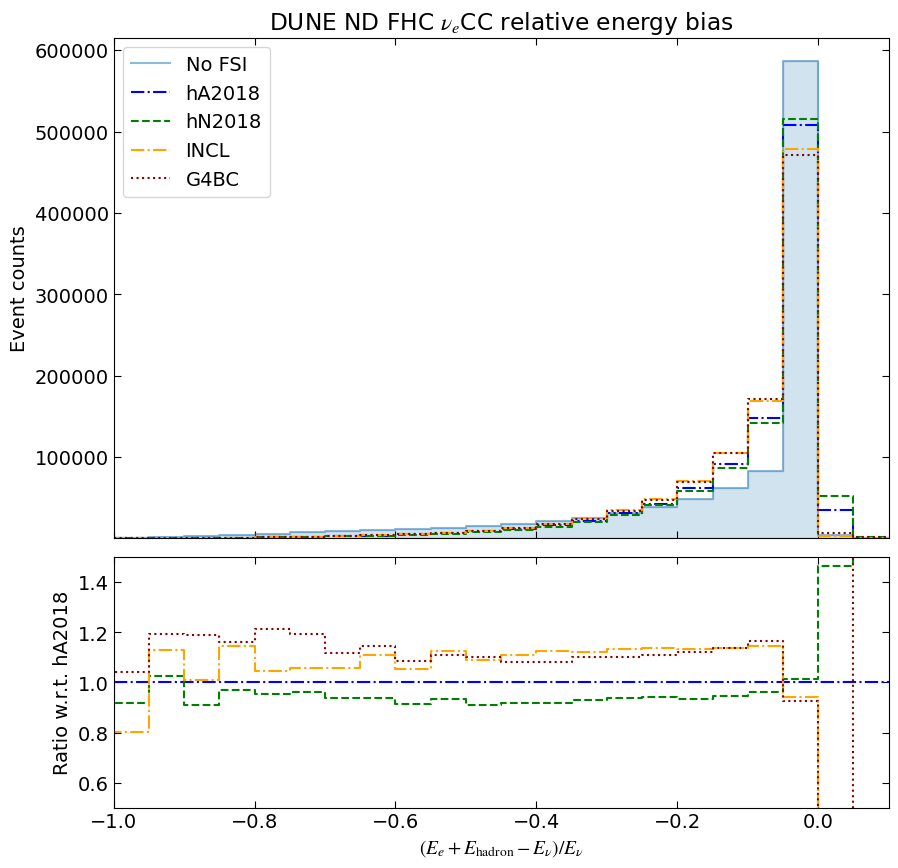

#events: 763530 833007 836683 829327 818019


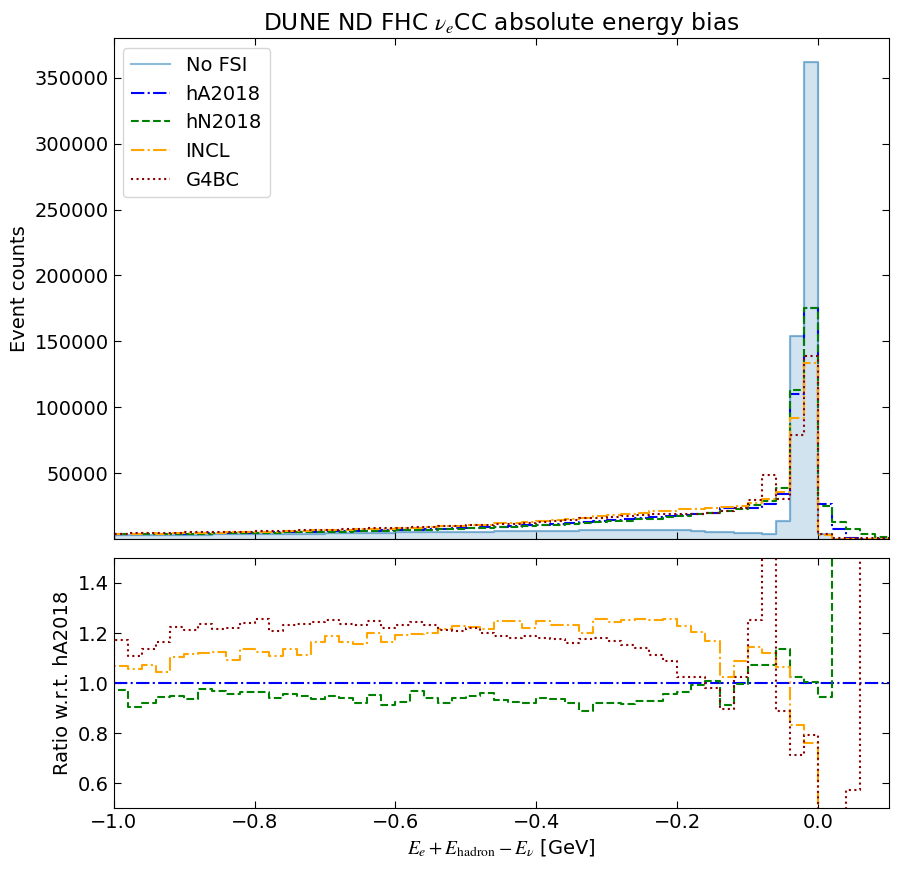

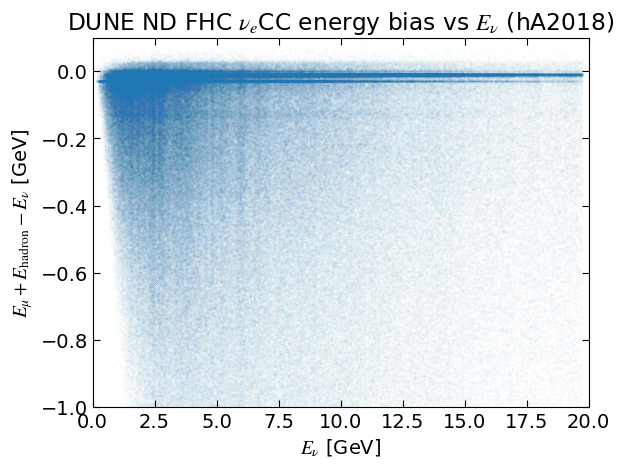

In [5]:
### relative energy bias
xx = np.linspace(-1, 0.1, 22+1)
yyi, _ = np.histogram(Ebiasi_nue_hA18/vars_nue_hA18["Ev"], bins=xx); yyi = np.concatenate([[0],yyi])
yyf_hA18, _ = np.histogram(Ebiasf_nue_hA18/vars_nue_hA18["Ev"], bins=xx); yyf_hA18 = np.concatenate([[0],yyf_hA18])
yyf_hN18, _ = np.histogram(Ebiasf_nue_hN18/vars_nue_hN18["Ev"], bins=xx); yyf_hN18 = np.concatenate([[0],yyf_hN18])
yyf_INCL, _ = np.histogram(Ebiasf_nue_INCL/vars_nue_INCL["Ev"], bins=xx); yyf_INCL = np.concatenate([[0],yyf_INCL])
yyf_G4BC, _ = np.histogram(Ebiasf_nue_G4BC/vars_nue_G4BC["Ev"], bins=xx); yyf_G4BC = np.concatenate([[0],yyf_G4BC])
print("Check if all having the same #events:", np.sum(yyi), np.sum(yyf_hA18), np.sum(yyf_hN18), np.sum(yyf_INCL), np.sum(yyf_G4BC))

fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})

axes[0].step(xx, yyi, label="No FSI", alpha=0.5, color='tab:blue')
axes[0].fill_between(xx, yyi, step="pre", alpha=0.2, color='tab:blue')
axes[0].step(xx, yyf_hA18, "-.", label="hA2018", color='blue')
axes[0].step(xx, yyf_hN18, "--", label="hN2018", color='green')
axes[0].step(xx, yyf_INCL, "-.", label="INCL", color='orange')
axes[0].step(xx, yyf_G4BC, ":", label="G4BC", color='darkred')
axes[0].legend()
axes[0].set_ylabel("Event counts")
axes[0].set_title(r"DUNE ND FHC $\nu_e$CC relative energy bias")
#axes[0].set_yscale('log')
axes[0].set_ylim([0.6, None])
axes[0].set_xlim([-1, 0.1])

axes[1].step(xx, safe_divide(yyf_hA18, yyf_hA18), "-.", label="hA2018", color='blue')
axes[1].step(xx, safe_divide(yyf_hN18, yyf_hA18), "--", label="hN2018", color='green')
axes[1].step(xx, safe_divide(yyf_INCL, yyf_hA18), "-.", label="INCL", color='orange')
axes[1].step(xx, safe_divide(yyf_G4BC, yyf_hA18), ":", label="G4BC", color='darkred')
axes[1].set_xlabel(r"$(E_e+E_{\rm hadron}-E_\nu)/E_\nu$")
axes[1].set_ylabel("Ratio w.r.t. hA2018")
axes[1].set_xlim([-1, 0.1])
axes[1].set_ylim([0.5, 1.5])
#plt.savefig("FSIplots/relaEvbias_Ehad_FSI_nue.png")
plt.show()


### absolute energy bias
xlow, xupp = -1, 0.1
xx = np.linspace(xlow, xupp, 55+1)
yyi, _ = np.histogram(Ebiasi_nue_hA18, bins=xx); yyi = np.concatenate([[0],yyi])
yyf_hA18, _ = np.histogram(Ebiasf_nue_hA18, bins=xx); yyf_hA18 = np.concatenate([[0],yyf_hA18])
yyf_hN18, _ = np.histogram(Ebiasf_nue_hN18, bins=xx); yyf_hN18 = np.concatenate([[0],yyf_hN18])
yyf_INCL, _ = np.histogram(Ebiasf_nue_INCL, bins=xx); yyf_INCL = np.concatenate([[0],yyf_INCL])
yyf_G4BC, _ = np.histogram(Ebiasf_nue_G4BC, bins=xx); yyf_G4BC = np.concatenate([[0],yyf_G4BC])
print("#events:", np.sum(yyi), np.sum(yyf_hA18), np.sum(yyf_hN18), np.sum(yyf_INCL), np.sum(yyf_G4BC))

fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})

axes[0].step(xx, yyi, label="No FSI", alpha=0.5, color='tab:blue')
axes[0].fill_between(xx, yyi, step="pre", alpha=0.2, color='tab:blue')
axes[0].step(xx, yyf_hA18, "-.", label="hA2018", color='blue')
axes[0].step(xx, yyf_hN18, "--", label="hN2018", color='green')
axes[0].step(xx, yyf_INCL, "-.", label="INCL", color='orange')
axes[0].step(xx, yyf_G4BC, ":", label="G4BC", color='darkred')
axes[0].legend()
axes[0].set_ylabel("Event counts")
axes[0].set_title(r"DUNE ND FHC $\nu_e$CC absolute energy bias")
#axes[0].set_yscale('log')
axes[0].set_ylim([0.6, None])
axes[0].set_xlim([xlow, xupp])

axes[1].step(xx, safe_divide(yyf_hA18, yyf_hA18), "-.", label="hA2018", color='blue')
axes[1].step(xx, safe_divide(yyf_hN18, yyf_hA18), "--", label="hN2018", color='green')
axes[1].step(xx, safe_divide(yyf_INCL, yyf_hA18), "-.", label="INCL", color='orange')
axes[1].step(xx, safe_divide(yyf_G4BC, yyf_hA18), ":", label="G4BC", color='darkred')
axes[1].set_xlabel(r"$E_e+E_{\rm hadron}-E_\nu$ [GeV]")
axes[1].set_ylabel("Ratio w.r.t. hA2018")
axes[1].set_xlim([xlow, xupp])
axes[1].set_ylim([0.5, 1.5])
#plt.savefig("FSIplots/absoEvbias_Ehad_FSI_nue.png")
plt.show()


### energy bias vs neutrino energy
plt.scatter(vars_nue_hA18["Ev"], Ebiasf_nue_hA18, alpha=0.1, s=0.01)
plt.xlabel(r"$E_\nu$ [GeV]")
plt.ylabel(r"$E_\mu+E_{\rm hadron}-E_\nu$ [GeV]")
plt.xlim(0, 20)
plt.ylim(xlow, xupp)
plt.title(r"DUNE ND FHC $\nu_e$CC energy bias vs $E_\nu$ (hA2018)")
#plt.savefig("FSIplots/2DEvbias_Ehad_hA18_nue.png")
plt.show()


/tmp/ipykernel_1393/1742096582.py:2: RuntimeWarning: divide by zero encountered in divide
  fluxND2FD_nue_1300 = FDosc_Flux_FHCnue_1300*1e7/ND_Flux_FHCnue


Check if all having the same #events: 9.999999999999996 10.0 9.999999999999998 10.0 10.000000000000002


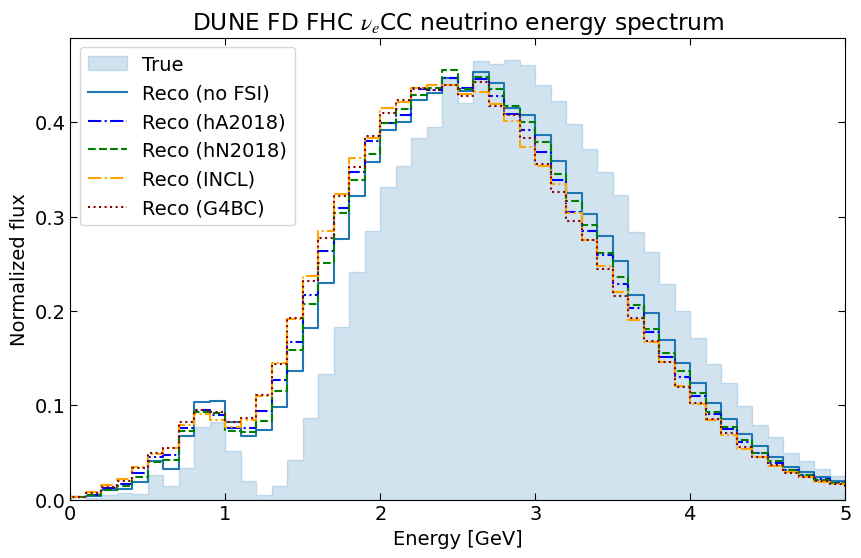

In [6]:
### oscillation plot
fluxND2FD_nue_1300 = FDosc_Flux_FHCnue_1300*1e7/ND_Flux_FHCnue
ND2FD_nue_wei_hA18 = np.interp(vars_nue_hA18["Ev"], FDosc_Ev, fluxND2FD_nue_1300)
ND2FD_nue_wei_hN18 = np.interp(vars_nue_hN18["Ev"], FDosc_Ev, fluxND2FD_nue_1300)
ND2FD_nue_wei_INCL = np.interp(vars_nue_INCL["Ev"], FDosc_Ev, fluxND2FD_nue_1300)
ND2FD_nue_wei_G4BC = np.interp(vars_nue_G4BC["Ev"], FDosc_Ev, fluxND2FD_nue_1300)
#plt.hist(vars_nue_hA18["Ev"], bins=100, alpha=0.3)
#plt.hist(vars_nue_hA18["Ev"], bins=100, alpha=0.3, weights=ND2FD_nue_wei_hA18)
#plt.show()

xx = np.arange(0, 20+0.1, 0.1)
yyt, _ = np.histogram(vars_nue_hA18["Ev"], bins=xx, weights=ND2FD_nue_wei_hA18, density=True); yyt = np.concatenate([[0],yyt])
yyi, _ = np.histogram(vars_nue_hA18["Ev"]+Ebiasi_nue_hA18, bins=xx, weights=ND2FD_nue_wei_hA18, density=True); yyi = np.concatenate([[0],yyi])
yyf_hA18, _ = np.histogram(vars_nue_hA18["Ev"]+Ebiasf_nue_hA18, bins=xx, weights=ND2FD_nue_wei_hA18, density=True); yyf_hA18 = np.concatenate([[0],yyf_hA18])
yyf_hN18, _ = np.histogram(vars_nue_hN18["Ev"]+Ebiasf_nue_hN18, bins=xx, weights=ND2FD_nue_wei_hN18, density=True); yyf_hN18 = np.concatenate([[0],yyf_hN18])
yyf_INCL, _ = np.histogram(vars_nue_INCL["Ev"]+Ebiasf_nue_INCL, bins=xx, weights=ND2FD_nue_wei_INCL, density=True); yyf_INCL = np.concatenate([[0],yyf_INCL])
yyf_G4BC, _ = np.histogram(vars_nue_G4BC["Ev"]+Ebiasf_nue_G4BC, bins=xx, weights=ND2FD_nue_wei_G4BC, density=True); yyf_G4BC = np.concatenate([[0],yyf_G4BC])
print("Check if all having the same #events:", np.sum(yyi), np.sum(yyf_hA18), np.sum(yyf_hN18), np.sum(yyf_INCL), np.sum(yyf_G4BC))

fig, ax = plt.subplots(figsize=(10, 6))
ax.fill_between(xx, yyt, step="pre", label="True", alpha=0.2, color='tab:blue')
ax.step(xx, yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
ax.step(xx, yyf_hA18, "-.", label="Reco (hA2018)", color='blue')
ax.step(xx, yyf_hN18, "--", label="Reco (hN2018)", color='green')
ax.step(xx, yyf_INCL, "-.", label="Reco (INCL)", color='orange')
ax.step(xx, yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
ax.legend()
ax.set_xlabel("Energy [GeV]")
ax.set_ylabel("Normalized flux")
ax.set_title(r"DUNE FD FHC $\nu_e$CC neutrino energy spectrum")
ax.set_ylim([0, None])
ax.set_xlim([0, 5])
#plt.savefig("FSIplots/FDoscNv_Eavail_FSI_nue.png")
plt.show()

/tmp/ipykernel_1393/1534257253.py:2: RuntimeWarning: divide by zero encountered in divide
  fluxND2FD_nue_1300_1 = FDosc_Flux_FHCnue_1300_1*1e7/ND_Flux_FHCnue
/tmp/ipykernel_1393/1534257253.py:3: RuntimeWarning: divide by zero encountered in divide
  fluxND2FD_nue_1300_2 = FDosc_Flux_FHCnue_1300_2*1e7/ND_Flux_FHCnue
/tmp/ipykernel_1393/1534257253.py:4: RuntimeWarning: divide by zero encountered in divide
  fluxND2FD_nue_1300_3 = FDosc_Flux_FHCnue_1300_3*1e7/ND_Flux_FHCnue


Check if all having the same #events: 5408389.662196042 10.0 5408054.10639 5409891.390460003 5400120.5546082705


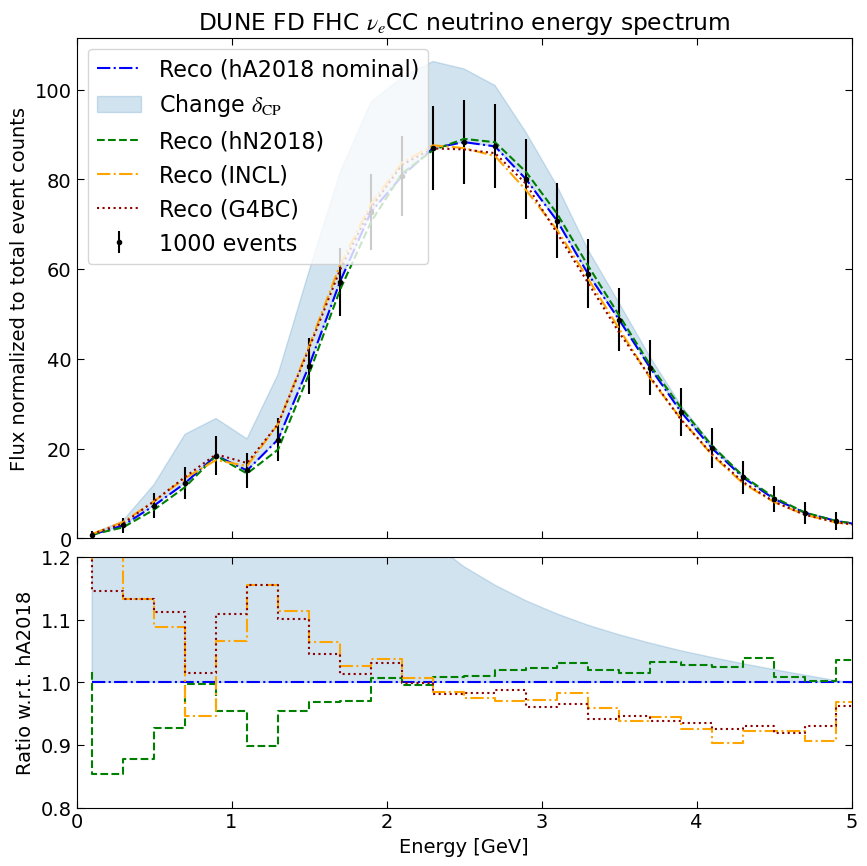

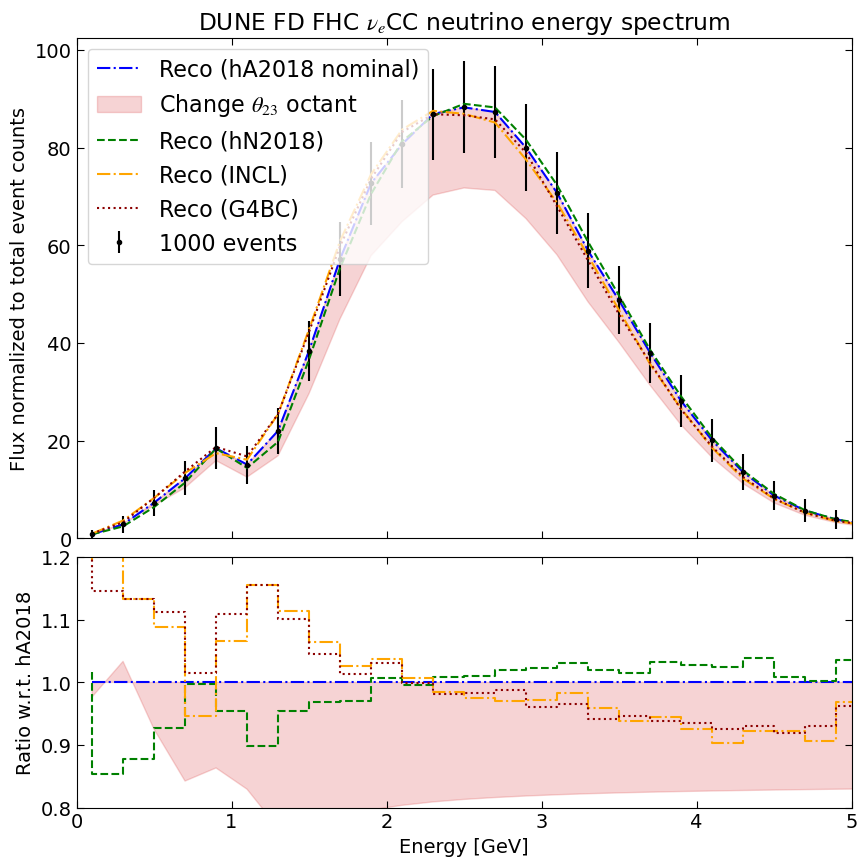

In [7]:
##### oscillation sensitivity
fluxND2FD_nue_1300_1 = FDosc_Flux_FHCnue_1300_1*1e7/ND_Flux_FHCnue
fluxND2FD_nue_1300_2 = FDosc_Flux_FHCnue_1300_2*1e7/ND_Flux_FHCnue
fluxND2FD_nue_1300_3 = FDosc_Flux_FHCnue_1300_3*1e7/ND_Flux_FHCnue

ND2FD_nue_wei_1300 = np.interp(vars_nue_hA18["Ev"], FDosc_Ev, fluxND2FD_nue_1300)
ND2FD_nue_wei_1300_1 = np.interp(vars_nue_hA18["Ev"], FDosc_Ev, fluxND2FD_nue_1300_1)
ND2FD_nue_wei_1300_2 = np.interp(vars_nue_hA18["Ev"], FDosc_Ev, fluxND2FD_nue_1300_2)
ND2FD_nue_wei_1300_3 = np.interp(vars_nue_hA18["Ev"], FDosc_Ev, fluxND2FD_nue_1300_3)

xx = np.arange(0, 20+0.2, 0.2)
yyi, _ = np.histogram(vars_nue_hA18["Ev"]+Ebiasi_nue_hA18, bins=xx, weights=ND2FD_nue_wei_hA18)
yyf_hN18, _ = np.histogram(vars_nue_hN18["Ev"]+Ebiasf_nue_hN18, bins=xx, weights=ND2FD_nue_wei_hN18);
yyf_INCL, _ = np.histogram(vars_nue_INCL["Ev"]+Ebiasf_nue_INCL, bins=xx, weights=ND2FD_nue_wei_INCL);
yyf_G4BC, _ = np.histogram(vars_nue_G4BC["Ev"]+Ebiasf_nue_G4BC, bins=xx, weights=ND2FD_nue_wei_G4BC);
yyf_1300, _ = np.histogram(vars_nue_hA18["Ev"]+Ebiasf_nue_hA18, bins=xx, weights=ND2FD_nue_wei_1300); #yyf_1300 = np.concatenate([[0],yyf_1300])
yyf_1300_1, _ = np.histogram(vars_nue_hA18["Ev"]+Ebiasf_nue_hA18, bins=xx, weights=ND2FD_nue_wei_1300_1);
yyf_1300_2, _ = np.histogram(vars_nue_hA18["Ev"]+Ebiasf_nue_hA18, bins=xx, weights=ND2FD_nue_wei_1300_2);
yyf_1300_3, _ = np.histogram(vars_nue_hA18["Ev"]+Ebiasf_nue_hA18, bins=xx, weights=ND2FD_nue_wei_1300_3);
print("Check if all having the same #events:", np.sum(yyi), np.sum(yyf_hA18), np.sum(yyf_hN18), np.sum(yyf_INCL), np.sum(yyf_G4BC))

Nv = 1000 # estimated total event counts
scale = Nv/np.sum(yyf_1300)
xx = (xx[1:]+xx[:-1])/2

### δ_{CP}
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})
ax[0].plot(xx, scale*yyf_1300, "-.", label="Reco (hA2018 nominal)", alpha=1, color='blue')
ax[0].errorbar(xx, scale*yyf_1300, np.sqrt(scale*yyf_1300), fmt="k.", label=f"{Nv} events")
ax[0].fill_between(xx, scale*yyf_1300, scale*yyf_1300_1, label=r"Change $\delta_{\rm CP}$", alpha=0.2, color='tab:blue')
#ax[0].plot(xx, scale*yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
ax[0].plot(xx, scale*yyf_hN18, "--", label="Reco (hN2018)", color='green')
ax[0].plot(xx, scale*yyf_INCL, "-.", label="Reco (INCL)", color='orange')
ax[0].plot(xx, scale*yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
ax[0].legend(loc="upper left", fontsize=16)
ax[0].set_ylabel("Flux normalized to total event counts")
ax[0].set_title(r"DUNE FD FHC $\nu_e$CC neutrino energy spectrum")
ax[0].set_ylim([0, None])
ax[0].set_xlim([0, 5])

#ax_inset = fig.add_axes([0.5, 0.64, 0.35, 0.21])  # Adjust these values as needed
## Plot the same data on the inset axes
#ax_inset.plot(xx, scale*yyf_1300, "-.", label="Reco (hA2018 nominal)", alpha=1, color='blue')
#ax_inset.fill_between(xx, scale*yyf_1300, scale*yyf_1300_1, label=r"$\Delta m^2_{23}$ error band", alpha=0.2, color='tab:blue')
#ax_inset.errorbar(xx, scale*yyf_1300, np.sqrt(scale*yyf_1300), fmt="k.", label=f"{Nv} events")
##ax_inset.plot(xx, scale*yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
#ax_inset.plot(xx, scale*yyf_hN18, "--", label="Reco (hN2018)", color='green')
#ax_inset.plot(xx, scale*yyf_INCL, "-.", label="Reco (INCL)", color='orange')
#ax_inset.plot(xx, scale*yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
#ax_inset.set_ylim([0.3*scale, 0.6*scale])
#ax_inset.set_xlim([2, 2.8])
#ax_inset.grid(True)

ax[1].step(xx, safe_divide(yyf_1300, yyf_1300), "-.", label="hA2018", color='blue')
ax[1].step(xx, safe_divide(yyf_hN18, yyf_1300), "--", label="hN2018", color='green')
ax[1].step(xx, safe_divide(yyf_INCL, yyf_1300), "-.", label="INCL", color='orange')
ax[1].step(xx, safe_divide(yyf_G4BC, yyf_1300), ":", label="G4BC", color='darkred')
ax[1].fill_between(xx, safe_divide(yyf_1300_1, yyf_1300), safe_divide(yyf_1300, yyf_1300), alpha=0.2, color='tab:blue')
ax[1].set_xlabel(r"Energy [GeV]")
ax[1].set_ylabel("Ratio w.r.t. hA2018")
ax[1].set_ylim([0.8, 1.2])
#plt.savefig("FSIplots/FDoscNv_Eavail_FSI_nue_dCP.png")
plt.show()

### octant of θ_{23}
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})
ax[0].plot(xx, scale*yyf_1300, "-.", label="Reco (hA2018 nominal)", alpha=1, color='blue')
ax[0].errorbar(xx, scale*yyf_1300, np.sqrt(scale*yyf_1300), fmt="k.", label=f"{Nv} events")
ax[0].fill_between(xx, scale*yyf_1300, scale*yyf_1300_2, label=r"Change $\theta_{23}$ octant", alpha=0.2, color='tab:red')
#ax[0].plot(xx, scale*yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
ax[0].plot(xx, scale*yyf_hN18, "--", label="Reco (hN2018)", color='green')
ax[0].plot(xx, scale*yyf_INCL, "-.", label="Reco (INCL)", color='orange')
ax[0].plot(xx, scale*yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
ax[0].legend(loc="upper left", fontsize=16)
ax[0].set_ylabel("Flux normalized to total event counts")
ax[0].set_title(r"DUNE FD FHC $\nu_e$CC neutrino energy spectrum")
ax[0].set_ylim([0, None])
ax[0].set_xlim([0, 5])

#ax_inset = fig.add_axes([0.5, 0.64, 0.35, 0.21])  # Adjust these values as needed
## Plot the same data on the inset axes
#ax_inset.plot(xx, scale*yyf_1300, "-.", label="Reco (hA2018 nominal)", alpha=1, color='blue')
#ax_inset.errorbar(xx, scale*yyf_1300, np.sqrt(scale*yyf_1300), fmt="k.", label=f"{Nv} events")
#ax_inset.fill_between(xx, scale*yyf_t23m, scale*yyf_t23p, label=r"$\sin^2 \theta_{23}$ error band", alpha=0.2, color='tab:red')
#ax_inset.fill_between(xx, scale*yyf_t232m, scale*yyf_t232p, alpha=0.1, color='tab:red')
##ax_inset.plot(xx, scale*yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
#ax_inset.plot(xx, scale*yyf_hN18, "--", label="Reco (hN2018)", color='green')
#ax_inset.plot(xx, scale*yyf_INCL, "-.", label="Reco (INCL)", color='orange')
#ax_inset.plot(xx, scale*yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
#ax_inset.set_ylim([0.03*scale, 0.1*scale])
#ax_inset.set_xlim([2, 2.8])
#ax_inset.grid(True)

ax[1].step(xx, safe_divide(yyf_1300, yyf_1300), "-.", label="hA2018", color='blue')
ax[1].step(xx, safe_divide(yyf_hN18, yyf_1300), "--", label="hN2018", color='green')
ax[1].step(xx, safe_divide(yyf_INCL, yyf_1300), "-.", label="INCL", color='orange')
ax[1].step(xx, safe_divide(yyf_G4BC, yyf_1300), ":", label="G4BC", color='darkred')
ax[1].fill_between(xx, safe_divide(yyf_1300_2, yyf_1300), safe_divide(yyf_1300, yyf_1300), alpha=0.2, color='tab:red')
ax[1].set_xlabel(r"Energy [GeV]")
ax[1].set_ylabel("Ratio w.r.t. hA2018")
ax[1].set_ylim([0.8, 1.2])
#plt.savefig("FSIplots/FDoscNv_Eavail_FSI_nue_t23.png")
plt.show()


/tmp/ipykernel_1393/1804776854.py:2: RuntimeWarning: divide by zero encountered in divide
  fluxND2FD_nue_1300p = FDosc_Flux_FHCnue_1300p*1e7/ND_Flux_FHCnue
/tmp/ipykernel_1393/1804776854.py:3: RuntimeWarning: divide by zero encountered in divide
  fluxND2FD_nue_1300m = FDosc_Flux_FHCnue_1300m*1e7/ND_Flux_FHCnue


Check if all having the same #events: 5408389.662196042 10.0 5408054.10639 5409891.390460003 5400120.5546082705


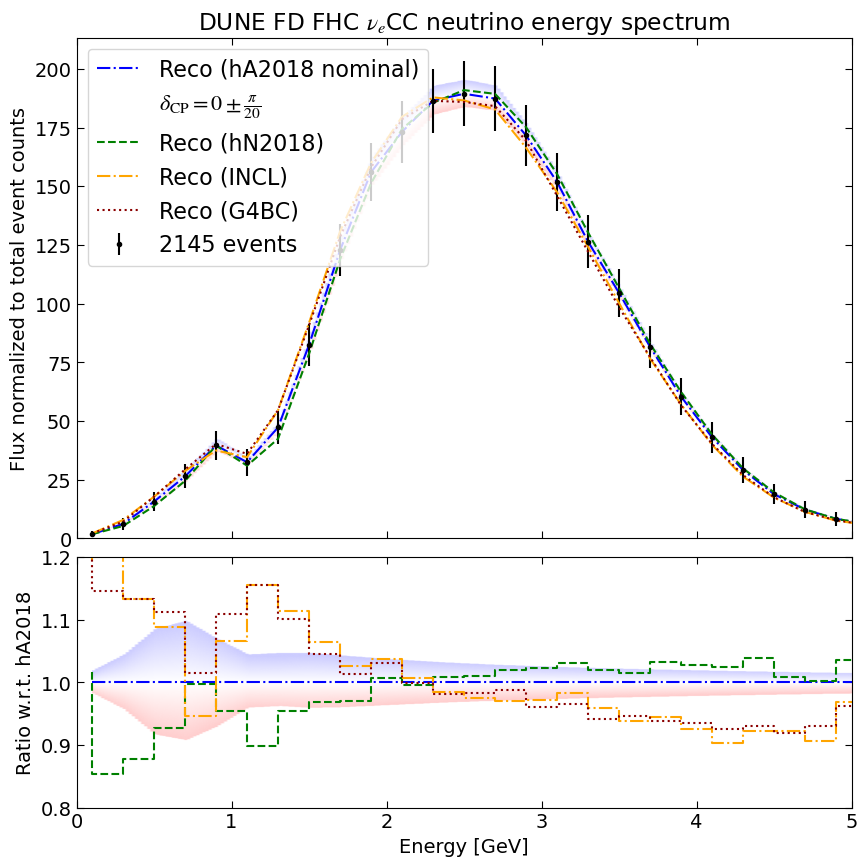

/tmp/ipykernel_1393/1804776854.py:66: RuntimeWarning: divide by zero encountered in divide
  fluxND2FD_nue_1300_1 = FDosc_Flux_FHCnue_1300_1*1e7/ND_Flux_FHCnue
/tmp/ipykernel_1393/1804776854.py:67: RuntimeWarning: divide by zero encountered in divide
  fluxND2FD_nue_1300_1p = FDosc_Flux_FHCnue_1300_1p*1e7/ND_Flux_FHCnue
/tmp/ipykernel_1393/1804776854.py:68: RuntimeWarning: divide by zero encountered in divide
  fluxND2FD_nue_1300_1m = FDosc_Flux_FHCnue_1300_1m*1e7/ND_Flux_FHCnue


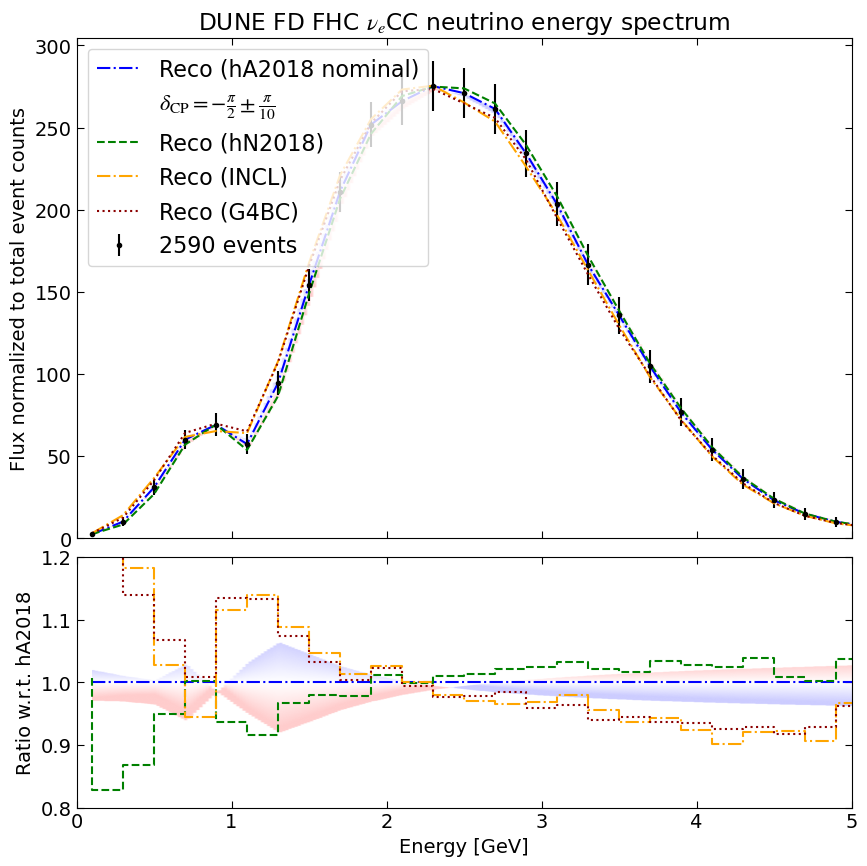

In [8]:
### oscillation sensitivity
fluxND2FD_nue_1300p = FDosc_Flux_FHCnue_1300p*1e7/ND_Flux_FHCnue
fluxND2FD_nue_1300m = FDosc_Flux_FHCnue_1300m*1e7/ND_Flux_FHCnue
ND2FD_nue_wei_1300p = np.interp(vars_nue_hA18["Ev"], FDosc_Ev, fluxND2FD_nue_1300p)
ND2FD_nue_wei_1300m = np.interp(vars_nue_hA18["Ev"], FDosc_Ev, fluxND2FD_nue_1300m)

xx = np.arange(0, 20+0.2, 0.2)
yyi, _ = np.histogram(vars_nue_hA18["Ev"]+Ebiasi_nue_hA18, bins=xx, weights=ND2FD_nue_wei_hA18)
yyf_hN18, _ = np.histogram(vars_nue_hN18["Ev"]+Ebiasf_nue_hN18, bins=xx, weights=ND2FD_nue_wei_hN18);
yyf_INCL, _ = np.histogram(vars_nue_INCL["Ev"]+Ebiasf_nue_INCL, bins=xx, weights=ND2FD_nue_wei_INCL);
yyf_G4BC, _ = np.histogram(vars_nue_G4BC["Ev"]+Ebiasf_nue_G4BC, bins=xx, weights=ND2FD_nue_wei_G4BC);
yyf_1300, _ = np.histogram(vars_nue_hA18["Ev"]+Ebiasf_nue_hA18, bins=xx, weights=ND2FD_nue_wei_1300); #yyf_1300 = np.concatenate([[0],yyf_1300])
yyf_1300p, _ = np.histogram(vars_nue_hA18["Ev"]+Ebiasf_nue_hA18, bins=xx, weights=ND2FD_nue_wei_1300p);
yyf_1300m, _ = np.histogram(vars_nue_hA18["Ev"]+Ebiasf_nue_hA18, bins=xx, weights=ND2FD_nue_wei_1300m);
print("Check if all having the same #events:", np.sum(yyi), np.sum(yyf_hA18), np.sum(yyf_hN18), np.sum(yyf_INCL), np.sum(yyf_G4BC))
xx = (xx[1:]+xx[:-1])/2

### δ_{CP} = 0
Nv = int(1155 *624/336) # estimated total event counts
scale = Nv/np.sum(yyf_1300)
fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})
ax[0].plot(xx, scale*yyf_1300, "-.", label="Reco (hA2018 nominal)", alpha=1, color='blue')
ax[0].errorbar(xx, scale*yyf_1300, np.sqrt(scale*yyf_1300), fmt="k.", label=f"{Nv} events")
ax[0].fill_between(xx, scale*yyf_1300p, scale*yyf_1300m, label=r"$\delta_{\rm CP}=0\pm\frac{\pi}{20}$", alpha=0, color='tab:blue')
fill_between_gradient(ax[0], xx, scale*yyf_1300, scale*yyf_1300p, scale*yyf_1300m, alpha=0.2)

#ax[0].plot(xx, scale*yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
ax[0].plot(xx, scale*yyf_hN18, "--", label="Reco (hN2018)", color='green')
ax[0].plot(xx, scale*yyf_INCL, "-.", label="Reco (INCL)", color='orange')
ax[0].plot(xx, scale*yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
ax[0].legend(loc="upper left", fontsize=16)
ax[0].set_ylabel("Flux normalized to total event counts")
ax[0].set_title(r"DUNE FD FHC $\nu_e$CC neutrino energy spectrum")
ax[0].set_ylim([0, None])
ax[0].set_xlim([0, 5])

#ax_inset = fig.add_axes([0.5, 0.64, 0.35, 0.21])  # Adjust these values as needed
## Plot the same data on the inset axes
#ax_inset.plot(xx, scale*yyf_1300, "-.", label="Reco (hA2018 nominal)", alpha=1, color='blue')
#ax_inset.fill_between(xx, scale*yyf_1300, scale*yyf_1300_1, label=r"$\Delta m^2_{23}$ error band", alpha=0.2, color='tab:blue')
#ax_inset.errorbar(xx, scale*yyf_1300, np.sqrt(scale*yyf_1300), fmt="k.", label=f"{Nv} events")
##ax_inset.plot(xx, scale*yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
#ax_inset.plot(xx, scale*yyf_hN18, "--", label="Reco (hN2018)", color='green')
#ax_inset.plot(xx, scale*yyf_INCL, "-.", label="Reco (INCL)", color='orange')
#ax_inset.plot(xx, scale*yyf_G4BC, ":", label="Reco (G4BC)", color='darkred')
#ax_inset.set_ylim([0.3*scale, 0.6*scale])
#ax_inset.set_xlim([2, 2.8])
#ax_inset.grid(True)

ax[1].step(xx, safe_divide(yyf_1300, yyf_1300), "-.", label="hA2018", color='blue')
ax[1].step(xx, safe_divide(yyf_hN18, yyf_1300), "--", label="hN2018", color='green')
ax[1].step(xx, safe_divide(yyf_INCL, yyf_1300), "-.", label="INCL", color='orange')
ax[1].step(xx, safe_divide(yyf_G4BC, yyf_1300), ":", label="G4BC", color='darkred')
#ax[1].fill_between(xx, safe_divide(yyf_1300p, yyf_1300), safe_divide(yyf_1300m, yyf_1300), alpha=0.2, color='tab:blue')
fill_between_gradient(ax[1], xx, np.ones_like(xx), safe_divide(yyf_1300p, yyf_1300), safe_divide(yyf_1300m, yyf_1300), alpha=0.2)
ax[1].set_xlabel(r"Energy [GeV]")
ax[1].set_ylabel("Ratio w.r.t. hA2018")
ax[1].set_ylim([0.8, 1.2])
plt.savefig("FSIplots/FDoscNv_Ehadreco_FSI_nue_dCP0.png")
plt.show()


### δ_{CP} = -pi/2
Nv = int(1395 *624/336) # estimated total event counts
scale = Nv/np.sum(yyf_1300)
fluxND2FD_nue_1300_1 = FDosc_Flux_FHCnue_1300_1*1e7/ND_Flux_FHCnue
fluxND2FD_nue_1300_1p = FDosc_Flux_FHCnue_1300_1p*1e7/ND_Flux_FHCnue
fluxND2FD_nue_1300_1m = FDosc_Flux_FHCnue_1300_1m*1e7/ND_Flux_FHCnue
ND2FD_nue_wei_1300_1 = np.interp(vars_nue_hA18["Ev"], FDosc_Ev, fluxND2FD_nue_1300_1)
ND2FD_nue_wei_1300_1p = np.interp(vars_nue_hA18["Ev"], FDosc_Ev, fluxND2FD_nue_1300_1p)
ND2FD_nue_wei_1300_1m = np.interp(vars_nue_hA18["Ev"], FDosc_Ev, fluxND2FD_nue_1300_1m)
ND2FD_nue_wei_hN18_1 = np.interp(vars_nue_hN18["Ev"], FDosc_Ev, fluxND2FD_nue_1300_1)
ND2FD_nue_wei_INCL_1 = np.interp(vars_nue_INCL["Ev"], FDosc_Ev, fluxND2FD_nue_1300_1)
ND2FD_nue_wei_G4BC_1 = np.interp(vars_nue_G4BC["Ev"], FDosc_Ev, fluxND2FD_nue_1300_1)
xx = np.arange(0, 20+0.2, 0.2)
yyf_hN18_1, _ = np.histogram(vars_nue_hN18["Ev"]+Ebiasf_nue_hN18, bins=xx, weights=ND2FD_nue_wei_hN18_1);
yyf_INCL_1, _ = np.histogram(vars_nue_INCL["Ev"]+Ebiasf_nue_INCL, bins=xx, weights=ND2FD_nue_wei_INCL_1);
yyf_G4BC_1, _ = np.histogram(vars_nue_G4BC["Ev"]+Ebiasf_nue_G4BC, bins=xx, weights=ND2FD_nue_wei_G4BC_1);
yyf_1300_1, _ = np.histogram(vars_nue_hA18["Ev"]+Ebiasf_nue_hA18, bins=xx, weights=ND2FD_nue_wei_1300_1);
yyf_1300_1p, _ = np.histogram(vars_nue_hA18["Ev"]+Ebiasf_nue_hA18, bins=xx, weights=ND2FD_nue_wei_1300_1p);
yyf_1300_1m, _ = np.histogram(vars_nue_hA18["Ev"]+Ebiasf_nue_hA18, bins=xx, weights=ND2FD_nue_wei_1300_1m);
xx = (xx[1:]+xx[:-1])/2

fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})
ax[0].plot(xx, scale*yyf_1300_1, "-.", label="Reco (hA2018 nominal)", alpha=1, color='blue')
ax[0].errorbar(xx, scale*yyf_1300_1, np.sqrt(scale*yyf_1300), fmt="k.", label=f"{Nv} events")
ax[0].fill_between(xx, scale*yyf_1300_1p, scale*yyf_1300_1m, label=r"$\delta_{\rm CP}=-\frac{\pi}{2}\pm\frac{\pi}{10}$", alpha=0, color='tab:blue')
fill_between_gradient(ax[0], xx, scale*yyf_1300_1, scale*yyf_1300_1p, scale*yyf_1300_1m, alpha=0.2)
#ax[0].plot(xx, scale*yyi, label="Reco (no FSI)", alpha=1, color='tab:blue')
ax[0].plot(xx, scale*yyf_hN18_1, "--", label="Reco (hN2018)", color='green')
ax[0].plot(xx, scale*yyf_INCL_1, "-.", label="Reco (INCL)", color='orange')
ax[0].plot(xx, scale*yyf_G4BC_1, ":", label="Reco (G4BC)", color='darkred')
ax[0].legend(loc="upper left", fontsize=16)
ax[0].set_ylabel("Flux normalized to total event counts")
ax[0].set_title(r"DUNE FD FHC $\nu_e$CC neutrino energy spectrum")
ax[0].set_ylim([0, None])
ax[0].set_xlim([0, 5])

ax[1].step(xx, safe_divide(yyf_1300_1, yyf_1300_1), "-.", label="hA2018", color='blue')
ax[1].step(xx, safe_divide(yyf_hN18_1, yyf_1300_1), "--", label="hN2018", color='green')
ax[1].step(xx, safe_divide(yyf_INCL_1, yyf_1300_1), "-.", label="INCL", color='orange')
ax[1].step(xx, safe_divide(yyf_G4BC_1, yyf_1300_1), ":", label="G4BC", color='darkred')
#ax[1].fill_between(xx, safe_divide(yyf_1300_1p, yyf_1300_1), safe_divide(yyf_1300_1m, yyf_1300_1), alpha=0.2, color='tab:blue')
fill_between_gradient(ax[1], xx, np.ones_like(xx), safe_divide(yyf_1300_1p, yyf_1300_1), safe_divide(yyf_1300_1m, yyf_1300_1), alpha=0.2)
ax[1].set_xlabel(r"Energy [GeV]")
ax[1].set_ylabel("Ratio w.r.t. hA2018")
ax[1].set_ylim([0.8, 1.2])
plt.savefig("FSIplots/FDoscNv_Ehadreco_FSI_nue_dCP-90.png")
plt.show()
